# Clustering-Analyse

## Inhalt ##

1. Clustering auf originalen Daten  
    1.1 Vorbereitung des Datensets für Clustering-Algorithmen  
    1.2 k-Means Clustering  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.2.1 Finden von Parametern mit "Elbow-Method"  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.2.2 Manuelle Suche von Cluster-Parametern  
    1.3 DBSCAN  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.3.1 Finden von Parametern mit "Elbow-Method"  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.3.2 Festlegen von Cluster-Parametern mit manueller Parametersuche  
    1.4 Gaussian Mixture Model  
    1.5 Hierarchichal Clustering  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.5.1 Finden von Parametern mit "Elbow-Method"  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.5.2 Manuelle Suche von Cluster-Parametern  
2. Durchführen des Clustering auf dimensionsreduzierten Daten  
    2.1 k-Means  
    2.2 DBSCAN  
    2.3 Gaussian Mixture Model  
    2.4 Hierarchichal Clustering  
3. Nähere Untersuchung des berechneten Cluster  
    3.1 Untersuchung anhand korrelierender Features  
    3.2 Untersuchung anhand von Themenbereichen  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.1 Untersuchung des Themenbereichs "Demographie"  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.2 Untersuchung des Themenbereichs "Kreativität"  
4. Fazit  

In [158]:
%store -r columns_encoded
%store -r columns
%store -r data
%store -r data_encoded

%store -r data_original_reduced_tsne
%store -r data_original_reduced_pca
%store -r data_original_reduced_kpca

%store -r data_topics_reduced_mean
%store -r data_topics_reduced_pca
%store -r data_topics_reduced_kpca
%store -r data_topics_reduced_tsne

columns_encoded = columns_encoded
columns = columns
input_data = data
data_encoded = data_encoded

data_original_reduced_tsne = data_original_reduced_tsne
data_original_reduced_pca = data_original_reduced_pca
data_original_reduced_kpca = data_original_reduced_kpca

data_topics_reduced_mean = data_topics_reduced_mean
data_topics_reduced_pca = data_topics_reduced_pca
data_topics_reduced_kpca = data_topics_reduced_kpca
data_topics_reduced_tsne = data_topics_reduced_tsne

In [196]:
import os
# Set environment variable (only relevant for Windows-OS). Necessary for avoiding warnings of memory leaks while executing cluster-algorithms.
os.environ["OMP_NUM_THREADS"] = '1'

In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import math

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_score

In [198]:
# !pip install yellowbrick
# %pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

# 1. Clustering auf originalen Daten

Zunächst soll versucht werden, die Daten basierend auf den Ursprungsdaten zu clustern. Hierbei ergibt sich jedoch die Herausforderung, die berechneten Cluster zur Auswertung angemessen darzustellen. Hierzu sollen die dimensionsreduzierte Daten genutzt werden. Da die Erkennbarkeit von Clustern dabei wiederum von den Berechnungen der Dimensionsreduzierung abhängen, werden die Cluster im Folgenden immer auch für die verschiedenen Ergebnisse der Dimensionsreduzierung ausgegeben.

## 1.1 Vorbereitung des Datensets für Clustering-Algorithmen

Damit die verwendeten Clustering-Algorithmen die Daten korrekt verarbeiten können, müssen ausschließlich numerische Features übergeben werden. Mithilfe des One-Hot-Encodings im Preprocessing wurden jedoch sowohl die demographischen Angaben wie Studiengang und Geschlecht als auch die Freitextfelder "Lieblingssportart", "Lieblingsessen" & "Lieblingsmusiker*in" (sowie das neue Feature "Genre") bereits in numerische Features übersetzt. Wie die Übersicht zeigt, sind in den vorverarbeiteten Daten somit bereits nur noch numerische Daten enthalten, sodass diesbezüglich keine weiteren Bearbeitungen notwendig sind.

In [199]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 82 columns):
 #   Column                                                                                                                      Non-Null Count  Dtype
---  ------                                                                                                                      --------------  -----
 0   Alter                                                                                                                       62 non-null     int64
 1   Als wie sportlich würdest du dich einschätzen?                                                                              62 non-null     int64
 2   Welche Rolle spielt für dich gesunde Ernährung?                                                                             62 non-null     int64
 3   Wie gerne gehst du Essen oder Trinken?                                                                                      62 non-null  

Eine Skalierung der Daten ist notwendig, damit die Clustering-Algorithmen keine verschiedenen Zahlenräume bei der Berechnung nutzen, die z. B. Features mit höheren Werten fälschlicherweise als "relevanter" erscheinen lassen. Zwar sind aufgrund der Form der Datenerhebung viele der Features auf Werte von 1-5 beschränkt; Einige Features wie z. B. das Alter lassen aber einen größeren Zahlenbereich zu, sodass eine Sklarierung durchaus sinnvoll bleibt. Außerdem bleibt das Vorgehen somit auch bei der (nachträglichen) Erweiterung der Features und/oder deren Werte anwendbar.

In [200]:
scaler = StandardScaler()
scaler.fit(data_encoded)
data_encoded_scaled = pd.DataFrame(scaler.transform(data_encoded),
                           columns= columns_encoded)

data_encoded_scaled.head()

Alter  Als wie sportlich würdest du dich einschätzen?  \
0  0.555073                                        0.728893   
1  0.105210                                       -0.298183   
2 -0.344653                                       -1.325259   
3 -0.569585                                        1.755968   
4 -0.344653                                       -0.298183   

   Welche Rolle spielt für dich gesunde Ernährung?   \
0                                          0.552967   
1                                          0.552967   
2                                          1.777393   
3                                         -1.895886   
4                                          0.552967   

   Wie gerne gehst du Essen oder Trinken?  Wie gerne kochst du selbst?  \
0                               -0.871197                     0.181800   
1                                0.147939                     1.206488   
2                                0.147939                     0.181800   
3                                0.147939                     0.181800   
4                               -0.871197                    -1.867577   

   Wie gerne gehst du feiern?  Wie sehr interessierst du dich für Musik?  \
0                    0.153296                                   1.071517   
1                   -0.710737                                   0.000000   
2                    0.153296                                   1.071517   
3                   -0.710737                                  -1.071517   
4                   -1.574770                                  -1.071517   

   Wie gerne liest Du?  \
0             0.727409   
1            -0.912567   
2            -0.912567   
3            -0.092579   
4             0.727409   

   Wie sehr interessierst du dich für darstellende Künste\nwie Schauspiel, Tanz oder Gesang?  \
0                                           0.314127                                           
1                                           0.314127                                           
2                                           0.314127                                           
3                                          -0.532650                                           
4                                          -0.532650                                           

   Wie sehr interessierst du sich für Filme, Kino, Fernsehsendungen?  ...  \
0                                          -0.827253                  ...   
1                                           0.287740                  ...   
2                                           0.287740                  ...   
3                                           0.287740                  ...   
4                                           1.402733                  ...   

   Studiengang Daisy? (encoded)  Studiengang Mmi? (encoded)  \
0                     -0.690066                    1.216553   
1                     -0.690066                    1.216553   
2                     -0.690066                    1.216553   
3                     -0.690066                    1.216553   
4                     -0.690066                    1.216553   

   Funktion Student*In? (encoded)  \
0                        0.225494   
1                        0.225494   
2                        0.225494   
3                        0.225494   
4                        0.225494   

   Genre Lieblingsmusiker Alternative? (encoded)  \
0                                      -0.438529   
1                                      -0.438529   
2                                       2.280351   
3                                      -0.438529   
4                                      -0.438529   

   Genre Lieblingsmusiker Electro? (encoded)  \
0                                  -0.225494   
1                                  -0.225494   
2                                  -0.225494   
3                                  -0.225494   
4                                  -0.2254

Mithilfe einer Hilfsfunktion können die Berechnungserbnisse von verschiedenen Clustering-Instanzen mit verschiedenen Parameterwerten zusammen ausgegeben werden, um die berechneten Cluster visuell besser miteinander vergleichen zu können. 

In [201]:
# Input:
#   - results: Computation results as an array of tuples with the form [("<<plot title>>", [<<dataframe>>])],
#              where the dataframe has the x- & y-coordinates of the datapoints in the first and second column and the cluster-assigment in the 
#   - figsize_columns: number of columns which are used to layout the plotted graphs. The number of rows is depending on the number of 'results' and the given 'figsize_columns'.
#   - figsize (optional): Adjusts the width/height of the individual graphs, in case the scaling is different for different computations
# Ouput: The plotted graphs which represent the given data from 'results'

def display_clustering(data, figsize_columns, figsize = (15, 15)):
    figsize_rows = math.ceil(len(data) / figsize_columns)
    fig, ax = plt.subplots(figsize_rows, figsize_columns, figsize=figsize)
    fig.tight_layout(pad=3)

    for i in range(len(data)):
        plt.subplot(figsize_rows, figsize_columns, i+1).set_title(data[i][0])

        current_dataframe = data[i][1]
        plt.subplot(figsize_rows, figsize_columns, i+1).scatter(
            current_dataframe[current_dataframe.columns[0]],
            current_dataframe[current_dataframe.columns[1]],
            c=current_dataframe[current_dataframe.columns[2]],
            cmap="viridis")
    
    return fig

## 1.2 k-Means Clustering

K-Means ist ein abstandsbasierter, vergleichsweise einfacher Algorithmus. Anhand von zufällig gewählten Startpunkten für Clusterzentren wird iterativ versucht, die Distanz von den Datenpunkten zu den ihr zugeordneten Clusterzentren nach und nach zu verringern, bis schließlich eine Zuordnung erreicht ist, bei der sich die Position der Clusterzentren nicht mehr verändert. Die Anzahl der zu bildenden Cluster muss hierbei jedoch explizit angegeben werden, weshalb im Folgenden zunächst versucht wird, ein sinnhafte Anzahl von Clustern abzuschätzen.

### 1.2.1 Finden von Parametern mit "Elbow-Method"

Für die Wahl der Clusteranzahl gibt es keine feste Metrik, sondern nur Heuristiken zur Annäherung an einen geeigneten Wert. Eine davon ist die "Elbow-Method": Durch das Berechnen der Cluster mit k-Means für verschiedene Clustergrößen und die Berechnung der zugehörigen "Distortion"-Werte kann ein Anhaltspunkt für eine geeignete Clustergröße gefunden werden. Der "Distortion"-Wert bezeichnet hierbei die Summe der Fehlerquadrate (SSE). Im Optimalfall hat die hieraus entstehende Funktion einen "Knick", ab dem eine größere Clusteranzahl den "Distortion"-Wert nicht mehr signifikant verbessert.

Scitkit stellt hierzu einen eigenen Visualizer zum Berechnen und Darstellen der Methode bereit, der hier mit vier verschiedenen Eingaben genutzt wird.

c:\Users\Konstantin\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:156: YellowbrickWarning:

No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.

c:\Users\Konstantin\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:374: YellowbrickWarning:

No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning



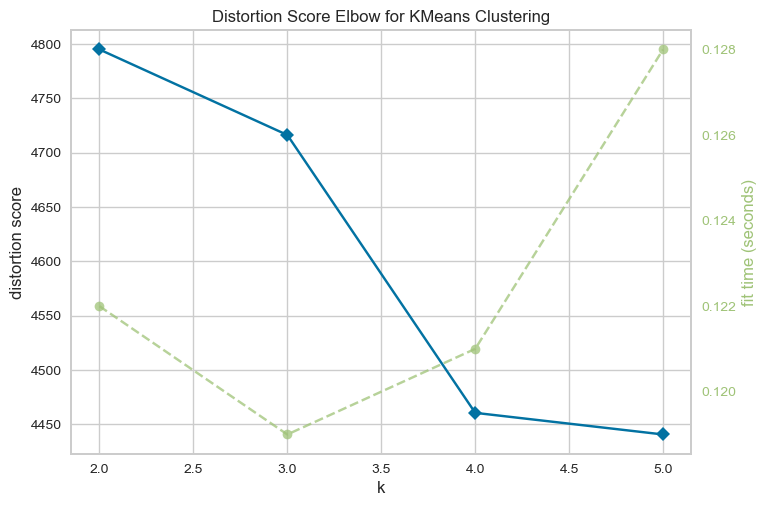

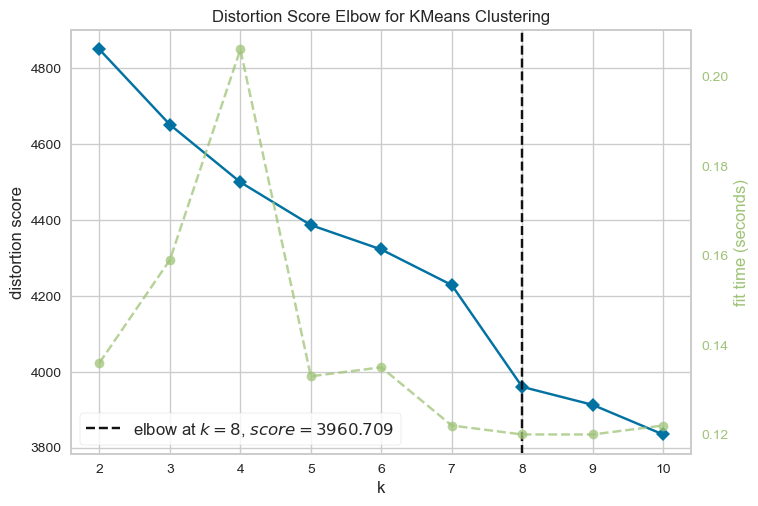

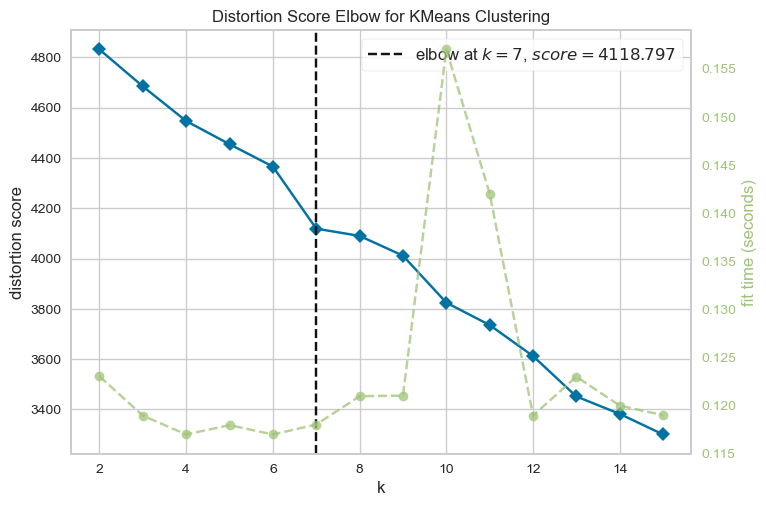

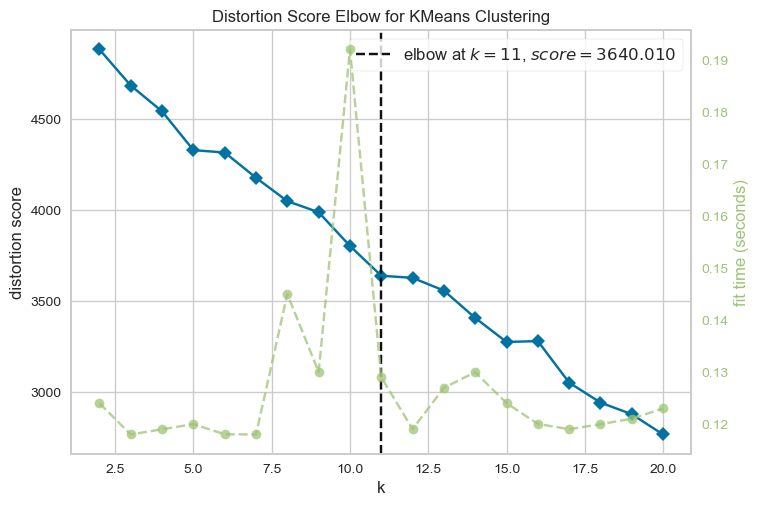

In [202]:
model = KMeans(n_init='auto')
param_ks = [5, 10, 15, 20]

for param_k in param_ks:
    visualizer = KElbowVisualizer(model, k=param_k)

    visualizer.fit(data_encoded_scaled)
    visualizer.show()

#### Erkenntnisse / Beobachtungen
Der "Distortion"-Wert nimmt bzgl. der Clusteranzahl k tendenziell linear ab, wodurch kein eindeutiger "Elbow" zu erkennen ist. Dies deutet darauf hin, dass es (zumindest gemäß dieser Heuristik) keine eindeutige Clusteranzahl zu geben scheint, bei der die Daten am besten eingeteilt werden. Dennoch empfiehlt der Algorithmus eine Clustergröße von ca. 7-11 als sinnvoll, was jedoch für die nähere Untersuchung der einzelnen Cluster eine zu große Anzahl wäre. Somit lässt sich feststellen, dass das Finden einer geeigneten Clustergröße mit der "Elbow"-Methode nicht zielführend zu sein scheint.

### 1.2.2 Manuelle Suche von Cluster-Parametern

Da das Bestimmen der Clustergröße mit der "Elbow-Method" nicht eindeutig war, werden nun "manuell" verschiedene Parameterwerte für k-Means berechnet. Das Vorgehen erinnert hierbei an eine GridSearch zum Finden optimaler Parameter eines Machine-Learning-Modells. Die zugehörige Bibliothek kann hier aber nicht nützlich eingebracht werden, da eine entsprechende "Scoring"-Funktion angegeben werden müsste, die für Clustering-Algorithmen als "ill-defined-problem" nicht eindeutig definiert ist.

Stattdessen wird zur Berechnung eine verschachtelte for-Schleife genutzt. Diese ist an sich zwar ineffizient für die Berechnung: Aufgrund der vergleichsweise geringen Laufzeit & Komplexität von k-Means sowie die geringe Datenmenge ist die Nutzung an dieser Stelle aber vertretbar. Bei der Berechnung der Cluster wird gleichzeitig auch der "Silhouette Coefficient" zur späteren Bewertung der Cluster berechnet und gespeichert.

In [203]:
def compute_kmeans(input_data, evaluation_data, cluster_params_n_clusters):
    kmeans_iterations = []
    kmeans_scores = pd.DataFrame(columns=["n_samples", "score"])

    for param_cluster in cluster_params_n_clusters:
        parameter_string = "n_samples: " + str(param_cluster)
        kmeans = KMeans(n_clusters=param_cluster, random_state=0, n_init='auto').fit(input_data)

        evaluation_data_copy = evaluation_data.copy()
        evaluation_data_copy["cluster"] = kmeans.labels_
        kmeans_iterations.append((parameter_string, evaluation_data_copy))

        score = silhouette_score(evaluation_data, kmeans.labels_)
        kmeans_scores.loc[len(kmeans_scores)] = {'n_samples':param_cluster, 'score':score}
    
    return kmeans_iterations, kmeans_scores

In [204]:
cluster_params_n_clusters = [3, 4, 5]

kmeans_iterations_pca, kmeans_scores_pca = compute_kmeans(data_encoded_scaled, data_original_reduced_pca, cluster_params_n_clusters)
kmeans_iterations_kpca, kmeans_scores_kpca = compute_kmeans(data_encoded_scaled, data_original_reduced_kpca, cluster_params_n_clusters)
kmeans_iterations_tsne, kmeans_scores_tsne = compute_kmeans(data_encoded_scaled, data_original_reduced_tsne, cluster_params_n_clusters)

Die berechneten Cluster werden nun mithilfe der dimensionsreduzierten Daten visualiert. In jeder Reihe werden hierbei die Ergebnisse der verschiedenen Verfahren zur Dimensionsreduzierung (PCA, Kernel PCA, t-SNE) dargestellt; In den Spalten sind jeweils die verschiedenen Clustergrößen von k-Means dargestellt. So kann in der Kombination bewertet werden, ob das Clustering mit den dimensionsreduzierten Daten zusammenpasst.

Text(0.5, 0.98, 't-SNE')

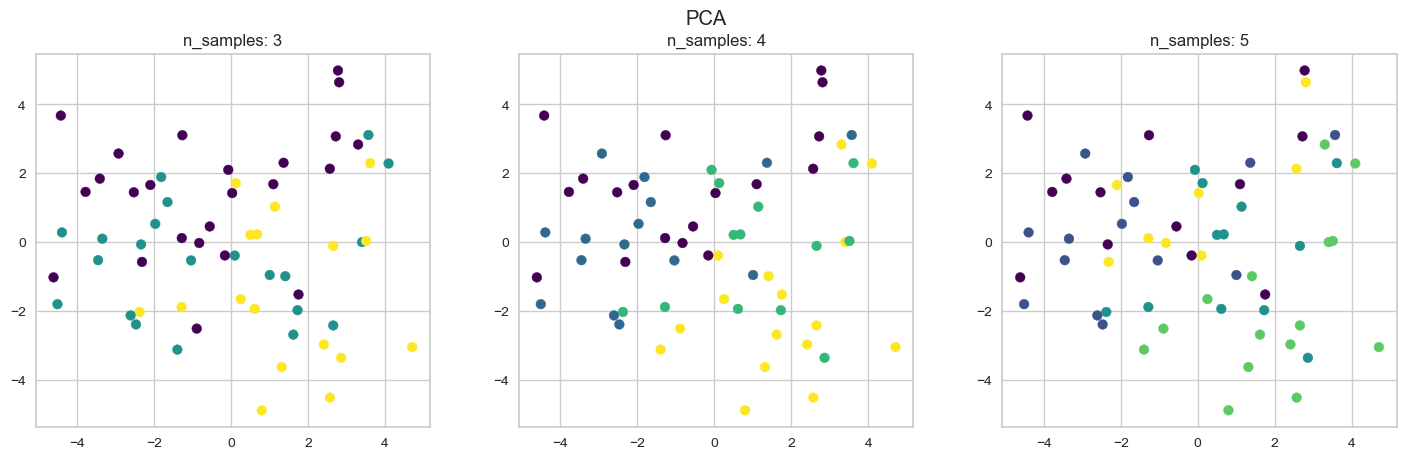

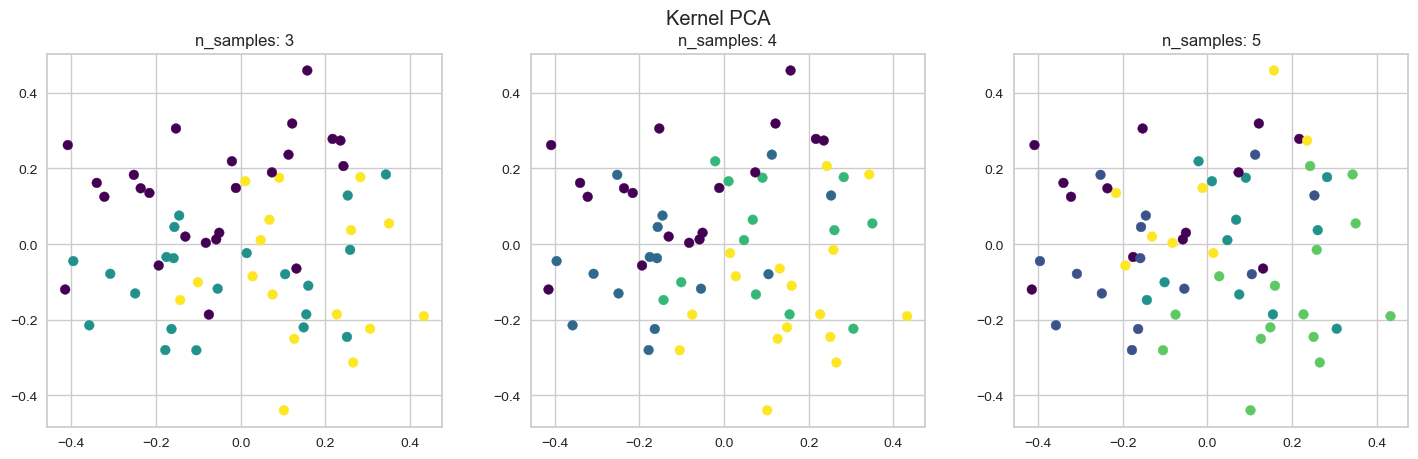

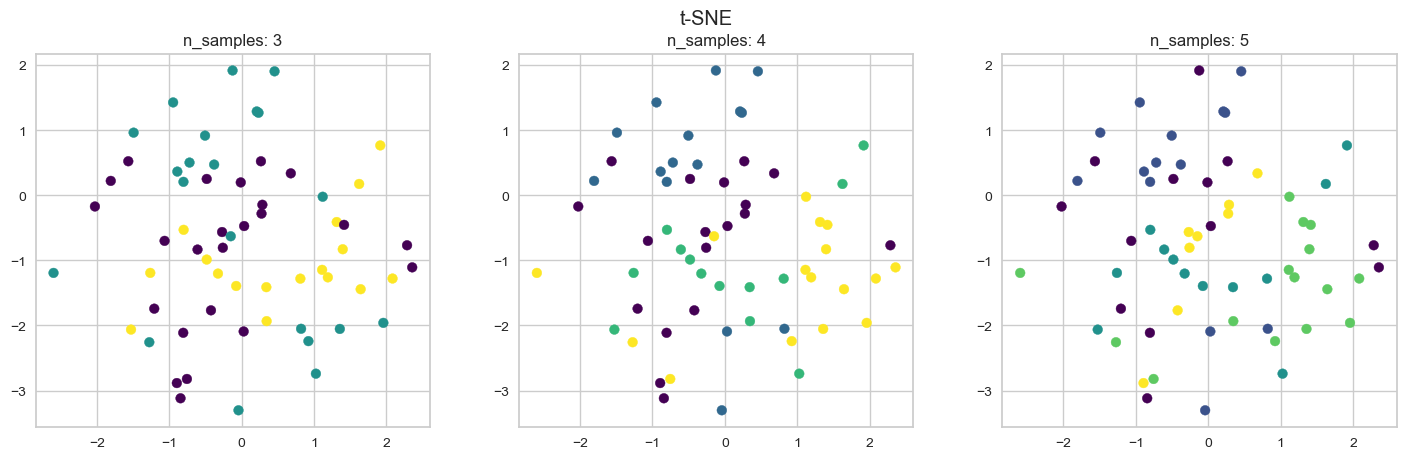

In [205]:
fig_pca = display_clustering(kmeans_iterations_pca, 3, (15, 5))
fig_pca.suptitle("PCA")

fig_kpca = display_clustering(kmeans_iterations_kpca, 3, (15, 5))
fig_kpca.suptitle("Kernel PCA")

fig_tsne = display_clustering(kmeans_iterations_tsne, 3, (15, 5))
fig_tsne.suptitle("t-SNE")

Neben der rein visuellen Auswertung kann auch der "Silhouette Coefficient" im Rahmen der "Silhouette Analysis" zur Bewertung der Cluster genutzt werden. Dieser ist je Cluster laut der [Dokumentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) wie folgt zu interpretieren:
- Wert < 0: Datenpunkt wurde ggf. einem falschen Cluster zugeordnet
- Wert nahe 0: Datenpunkt befindet sich an Rand eines Clusters und wurde bei Abstandsmessung ggf. dem falschen Cluster zugeordnet
- Wert > 0: Der Datenpunkt ist vergleichsweise weit vom nächsten Cluster entfernt (und somit vergleichsweise eindeutig zugeordnet)

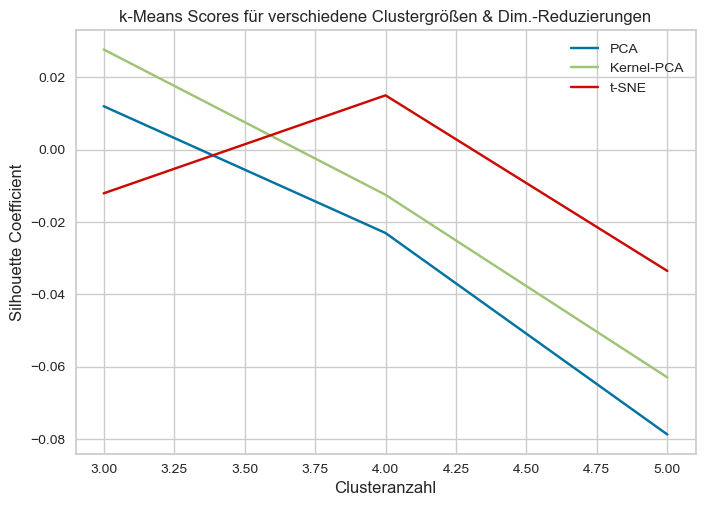

In [206]:
plt.plot(kmeans_scores_pca.n_samples, kmeans_scores_pca.score, label="PCA")
plt.plot(kmeans_scores_kpca.n_samples, kmeans_scores_kpca.score, label="Kernel-PCA")
plt.plot(kmeans_scores_tsne.n_samples, kmeans_scores_tsne.score, label="t-SNE")
plt.xlabel("Clusteranzahl")
plt.ylabel("Silhouette Coefficient")
plt.title("k-Means Scores für verschiedene Clustergrößen & Dim.-Reduzierungen")
plt.legend()
plt.show()

### Ergebnisse / Beobachtungen
Sowohl die Plots, als auch die Scores der "Silhouette Analysis" lassen feststellen, dass die Einteilung der Daten in Cluster mit k-Means grundsätzlich funktioniert und die groben Clusterstrukturen in den dimensionsreduzierten Graphen zu erkennen sind. Wie in der "Silhouette Analysis" zu erkennen ist, hängt die optimale Clusteranzahl auch von der gewählten Dimensionsreduzierung ab: So würde auf Basis der von t-SNE berechneten Daten eine Clusteranzahl von 4 als optimal angesehen werden, bei (Kernel) PCA hingegen von 3. Eine detaillierte Bewertung der Cluster ist aber nur bei der Betrachtung einzelner Feature-Kombinationen möglich.

## 1.3 DBSCAN

DBSCAN ist im Gegensatz zu k-Means ein dichtebasiertes Verfahren, wodurch auch komplexere Clusterformen wie Ringstrukturen erkannt werden können. Weiterhin muss bei DBSCAN nicht explizit die Anzahl der zu erkennenden Cluster angegeben werden, da diese selbstständig auf Basis der Dichteverteilung ermittelt wird. Dadurch ist es außerdem möglich, Ausreißer als "Noise" zu erkennen und diese somit keinem Cluster zuzuordnen. Dafür benötigt der Algorithmus jedoch die Angabe der zwei Parameter "minPts" (Maß für Erreichbarkeit eines Punktes) und "epsilon" (Nachbarschaftslänge), die die Berechnung der Cluster stark beeinflussen können.

### 1.3.1 Finden von Parametern mit "Elbow-Method"

Analog zur "Elbow-Method" für k-Means kann ein ähnliches Verfahren genutzt werden, um den "epsilon"-Wert für DBSCAN abzuschätzen. Das Vorgehen nach [Rahmah and Sitanggang, 2016](https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf) berechnet die durchschnittliche Distanz von jedem Datenpunkt zu seinen "n_neighbors", die später die "minPts" darstellen. In dem entstehenden Graphen kann dann der Punkt abgelesen werden, ab dem ein kleinerer Wert keinen nennenswerten positiven Einfluss mehr auf die Clusterbildung hat. Dieser Wert könnte dann als "epsilon" Wert gewählt werden. Das Vorgehen orientiert sich an einem [Online-Artikel](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd) von Tara Mullin.

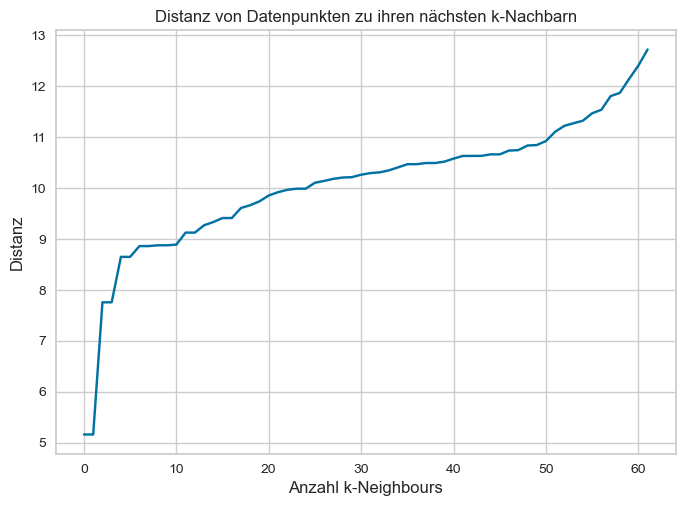

In [207]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(data_encoded_scaled)
distances, indices = neighbors_fit.kneighbors(data_encoded_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.title("Distanz von Datenpunkten zu ihren nächsten k-Nachbarn")
plt.xlabel("Anzahl k-Neighbours")
plt.ylabel("Distanz")
plt.plot(distances)

#### Ergebnisse / Beobachtungen
Der berechnete Graph entspricht nicht der Form, in der man einen "Knick" als "Elbow" ablesen könnte. Somit kann aus dem Graphen lediglich der möglicherweise sinnhaft zu untersuchende Zahlenraum von ca. 5-13 für den Wert des "epsilon"-Parameters abgeschätzt werden.

### 1.3.2 Festlegen von Cluster-Parametern mit manueller Parametersuche

Analog zum Vorgehen bei k-Means werden im Folgenden verschiedene Parameter-Kombinationen getestet und jeweils mit den verschiedenen Ergebnissen der Dimensionsreduzierung verglichen. Während zumindest der Bereich des "epsilon"-Parameters durch die "Elbow-Method" abgeschätzt werden kann, ist eine solche Herleitung für den "minPts"-Parameter nicht möglich. Zwar existieren Empfehlungen wie bespielsweise von [Sander et al., 1998](https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf), die für mehrdimensionale Daten die doppelte Anzahl der Dimensionen vorschlagen. Aufgrund der großen Anzahl an Features und vergleichsweise geringen Anzahl an Datenpunkten wäre somit aber kein Clustering möglich (da ein Datenpunkt mehr erreichbare Datenpunkte bräuchte als es gibt). Daher werden auch für diesen Parameter verschiedene Werte ausprobiert und in der Ausgabe überprüft.

In [208]:
def compute_dbscan(input_data, evaluation_data, cluster_params_min_samples, cluster_params_eps):
    dbscan_iterations = []

    for min_samples in cluster_params_min_samples:
        for eps in cluster_params_eps:
            parameter_string = "eps: " + str(eps) + ", minPts: " + str(min_samples)

            dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(input_data)
            data_original_reduced_tsne_dbscan = evaluation_data.copy()
            data_original_reduced_tsne_dbscan["cluster"] = dbscan.labels_
            dbscan_iterations.append((parameter_string, data_original_reduced_tsne_dbscan))
    
    return dbscan_iterations

In [209]:
cluster_params_min_samples = [2, 3, 4, 5]
cluster_params_eps = [5, 10, 11, 12, 10.5, 10.25, 10.75, 13]

dbscan_iterations_pca = compute_dbscan(data_encoded_scaled, data_original_reduced_pca, cluster_params_min_samples, cluster_params_eps)
dbscan_iterations_kpca = compute_dbscan(data_encoded_scaled, data_original_reduced_kpca, cluster_params_min_samples, cluster_params_eps)
dbscan_iterations_tsne = compute_dbscan(data_encoded_scaled, data_original_reduced_tsne, cluster_params_min_samples, cluster_params_eps)

Text(0.5, 1.01, 't-SNE')

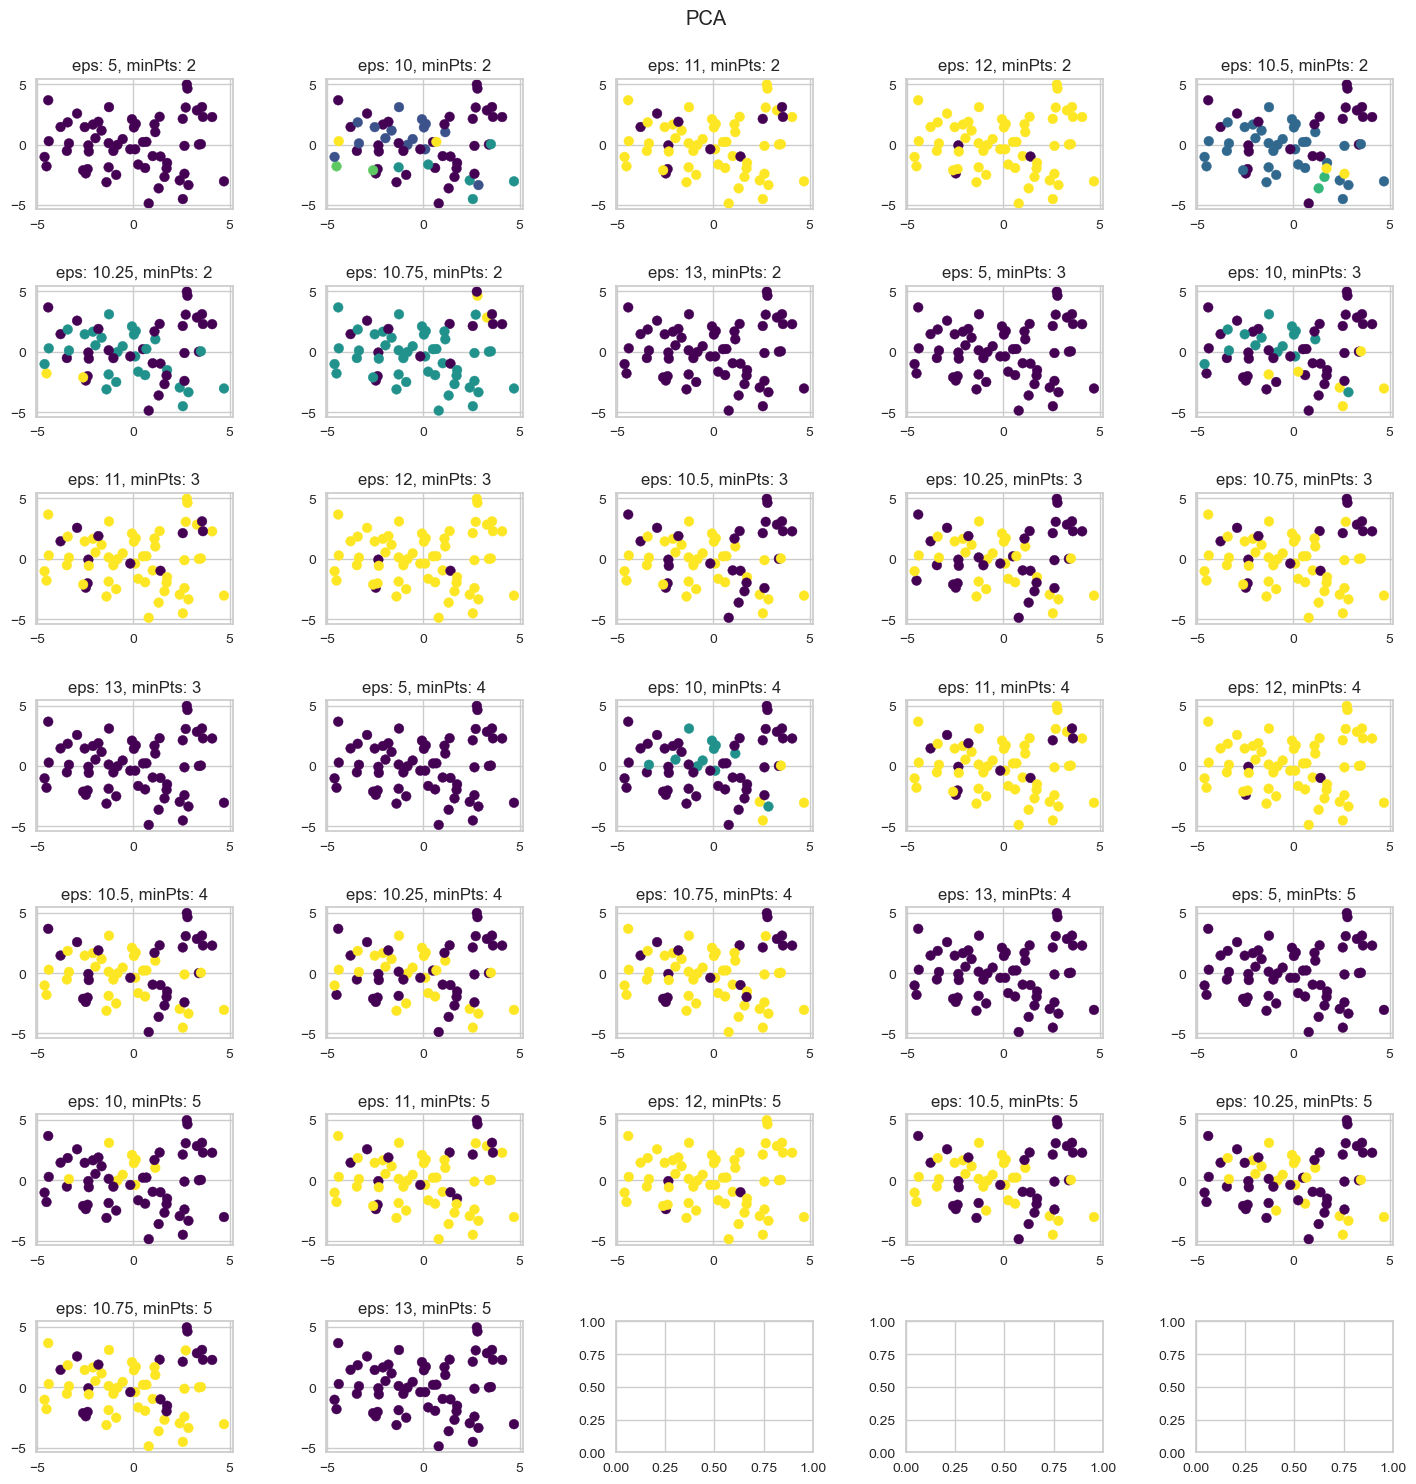

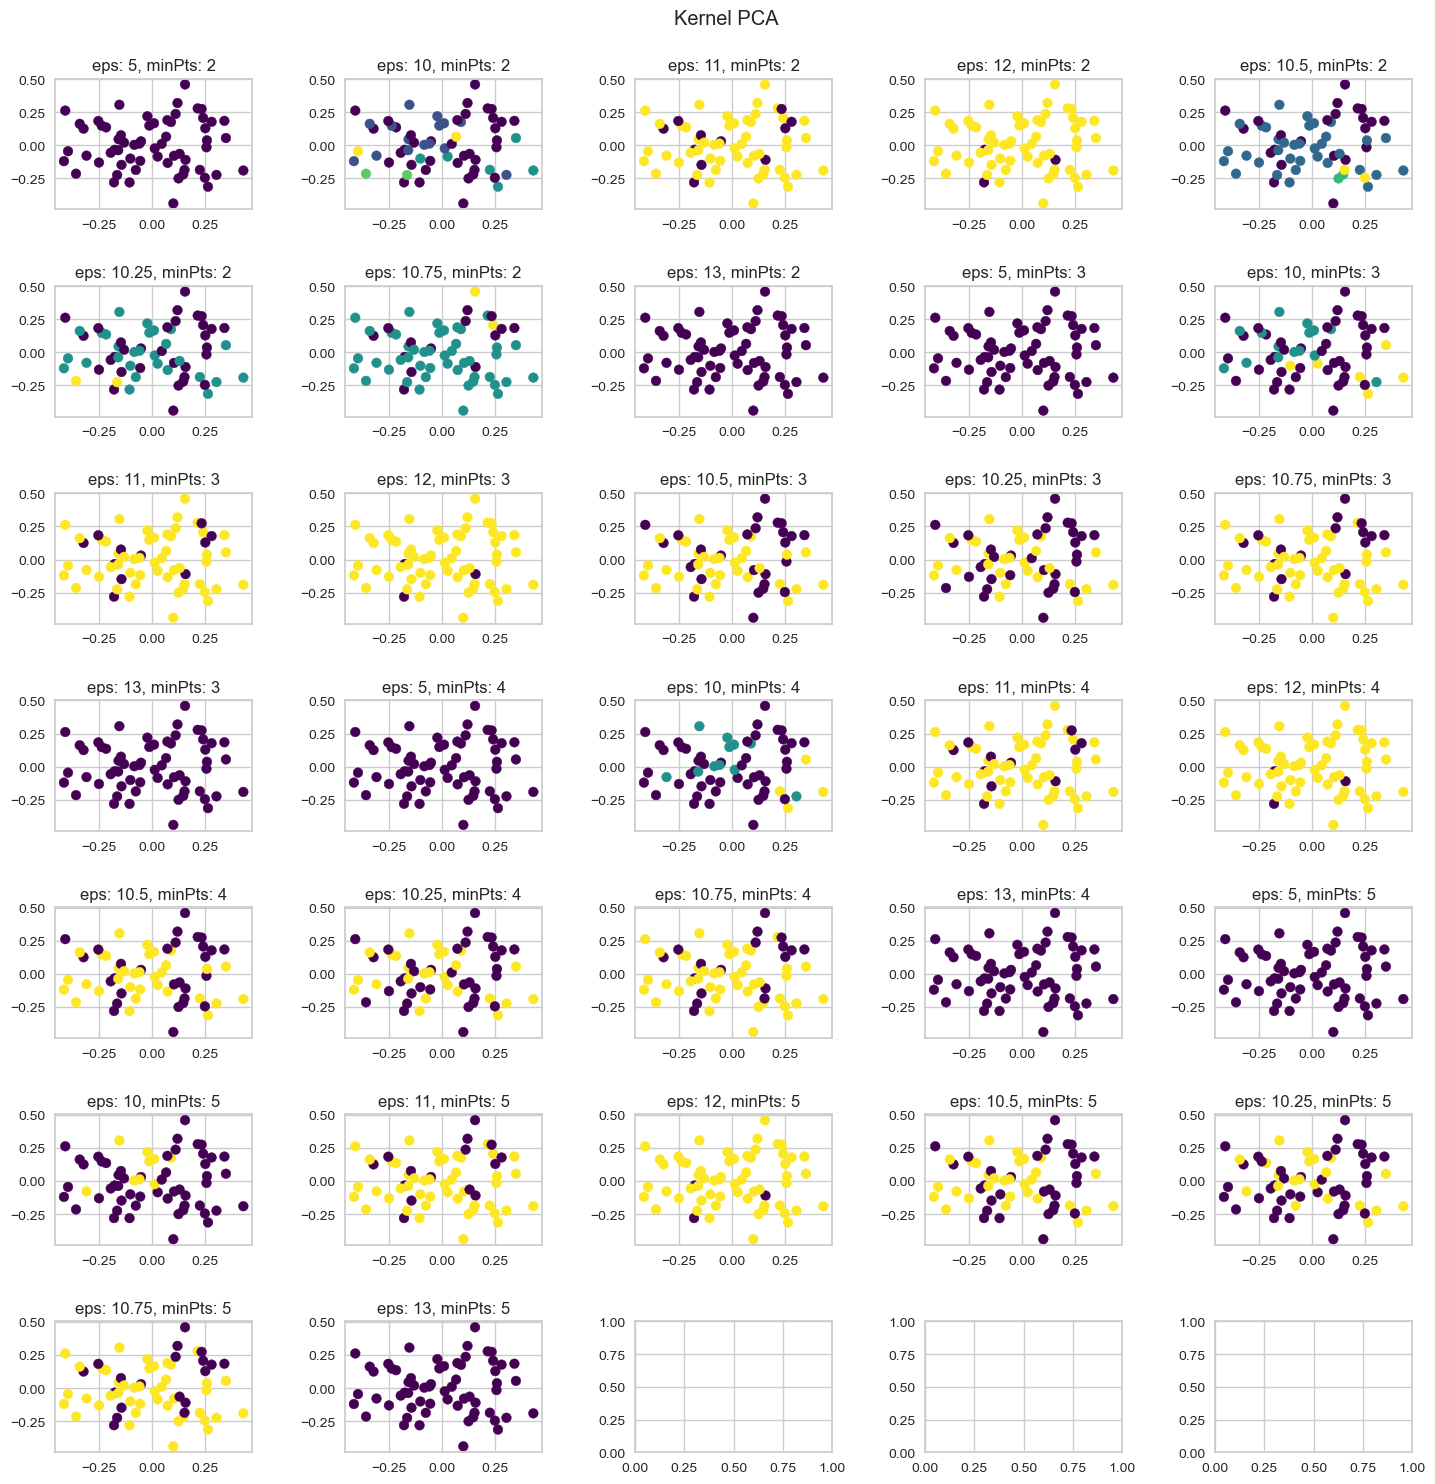

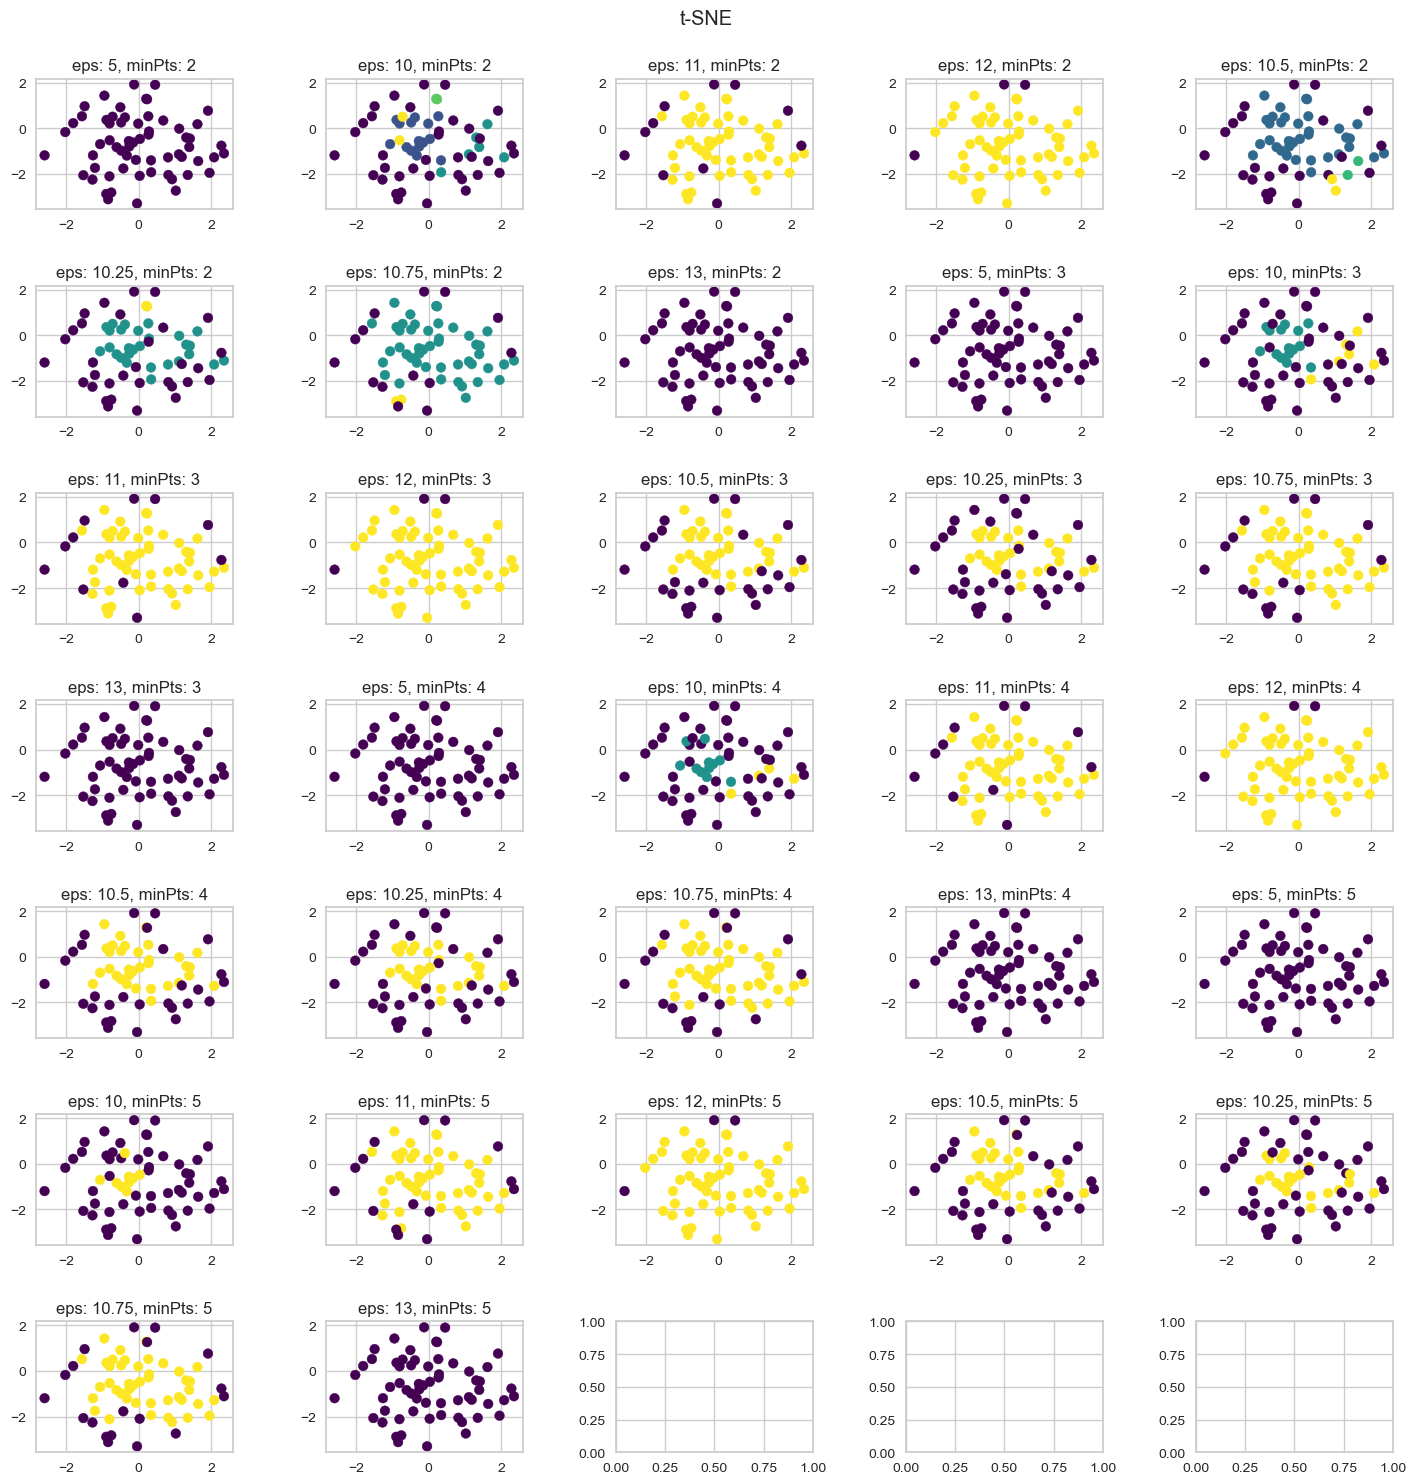

In [210]:
fig_pca = display_clustering(dbscan_iterations_pca, 5, (15, 15))
fig_pca.suptitle("PCA", y=1.01)

fig_kpca = display_clustering(dbscan_iterations_kpca, 5, (15, 15))
fig_kpca.suptitle("Kernel PCA", y=1.01)

fig_tsne = display_clustering(dbscan_iterations_tsne, 5, (15, 15))
fig_tsne.suptitle("t-SNE", y=1.01)

#### Erkenntnisse / Beobachtungen
Allgemein scheint das Clustering mit DBSCAN keine zielführenden Ergebnisse zu liefern. So wird für die meisten Parameter-Kombinationen maximal ein Cluster erkannt, das sich von der Mitte nach außen erstreckt. Lediglich für niedrige Werte des "minPts"-Parameters und gleichzeitig hohe Werte des "epsilon"-Parameters scheinen detailliertere Cluster erkannt zu werden. Da der "minPts"-Parameter durch die Angabe der zu erreichenden Nachbarpunkte eher restriktiv ist und der "epsilon"-Parameter hingegen die Möglichkeiten zur Clusterbildung vergrößert, erscheint dieses Verhalten nachvollziehbar.

Da aber auch diese Cluster eher willkürlich erscheinen, ist keines der Ergebnisse als zielführend anzusehen. Theoretisch könnten die Cluster auch nur auf den reduzierten Daten willkürlich erscheinen, und sich bei einer detaillierten Analyse einzelner Feauture als sinnvoll herausstellen. Da die Cluster im Optimalfall aber sowohl für einzelne Features, als auch auf den reduzierten Daten erkennbar sein sollten, und die Ergebnisse anderer Verfahren diese Anforderung besser erfüllen, wird das Clustering mit DBSCAN nicht weiterverfolgt.

## 1.4 Gaussian Mixture Model

Genau wie DBSCAN ist das Gaussian Mixture Model (GMM) ein dichtebasiertes Verfahren, dass das Clustering mithilfe von Gauss-Verteilungen berechnet. Hierdurch können wie mit DBSCAN auch komplexere Strukturen in den Daten erkannt werden. Im Unterschied zu den bisherigen Verfahren ermöglicht GMM dabei auch ein "soft clustering", d. h. ein Datenpunkt kann auch mehreren Clustern zugeordnet werden.

Ähnlich zu k-Means muss jedoch auch bei GMM die Anzahl der zu berechnenden Cluster explizit vorgegeben werden. Des Weiteren benötigt der Algorithmus eine ausreichend große Anzahl von Datenpunkten, um zielführende Cluster bilden zu können. Zum Finden einer geeigneten Anzahl von Clustern werden wie bei k-Means verschiedene Anzahlen ausprobiert und miteinander verglichen.

In [211]:
def compute_gm(input_data, evaluation_data, cluster_params_n_components):
        gm_iterations = []

        for n_component in cluster_params_n_components:
                parameter_string = "n_component: " + str(n_component)

                gm = GaussianMixture(n_components=n_component, random_state=0).fit(input_data)
                gm_labels = gm.predict(input_data)
                evaluation_data_copy = evaluation_data.copy()
                evaluation_data_copy["cluster"] = gm_labels
                gm_iterations.append((parameter_string, evaluation_data_copy))

        return gm_iterations

In [212]:
cluster_params_n_clusters = [3, 4, 5]

gm_iterations_pca = compute_gm(data_encoded_scaled, data_original_reduced_pca, cluster_params_n_clusters)
gm_iterations_kpca = compute_gm(data_encoded_scaled, data_original_reduced_kpca, cluster_params_n_clusters)
gm_iterations_tsne = compute_gm(data_encoded_scaled, data_original_reduced_tsne, cluster_params_n_clusters)

Text(0.5, 0.98, 't-SNE')

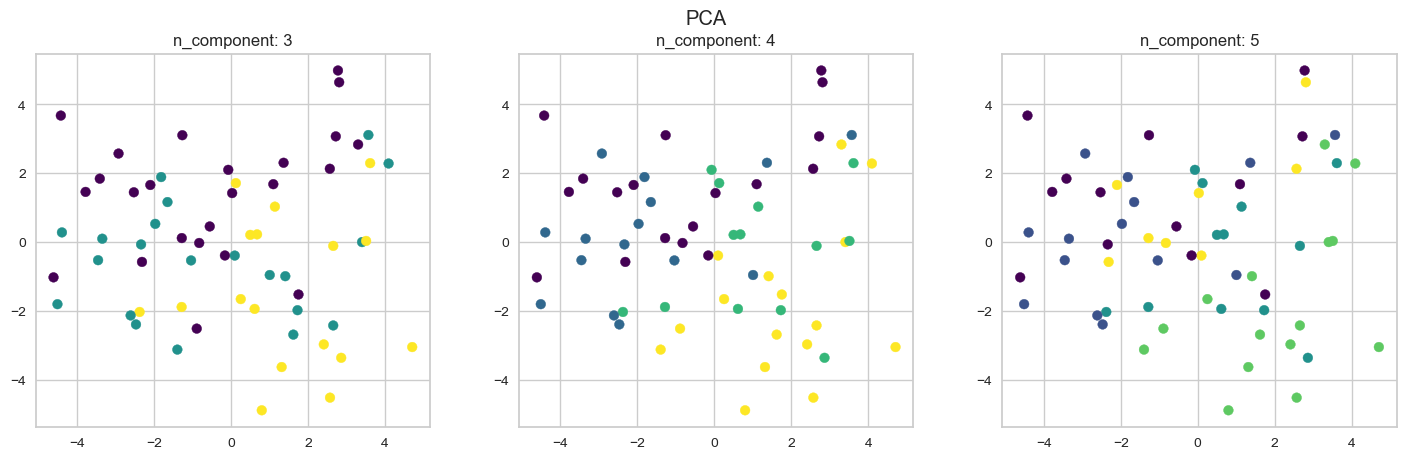

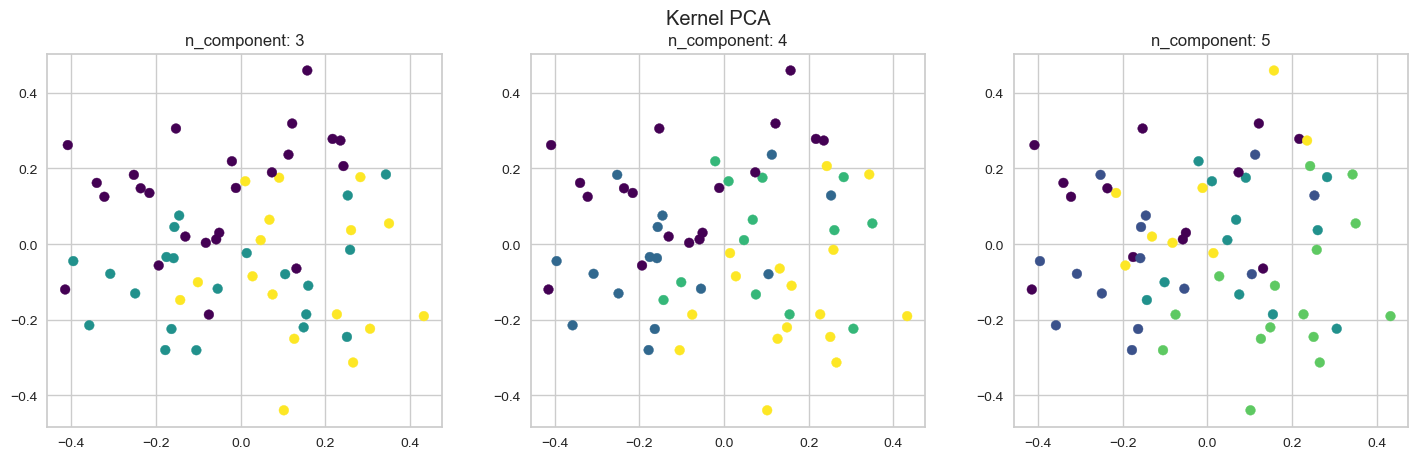

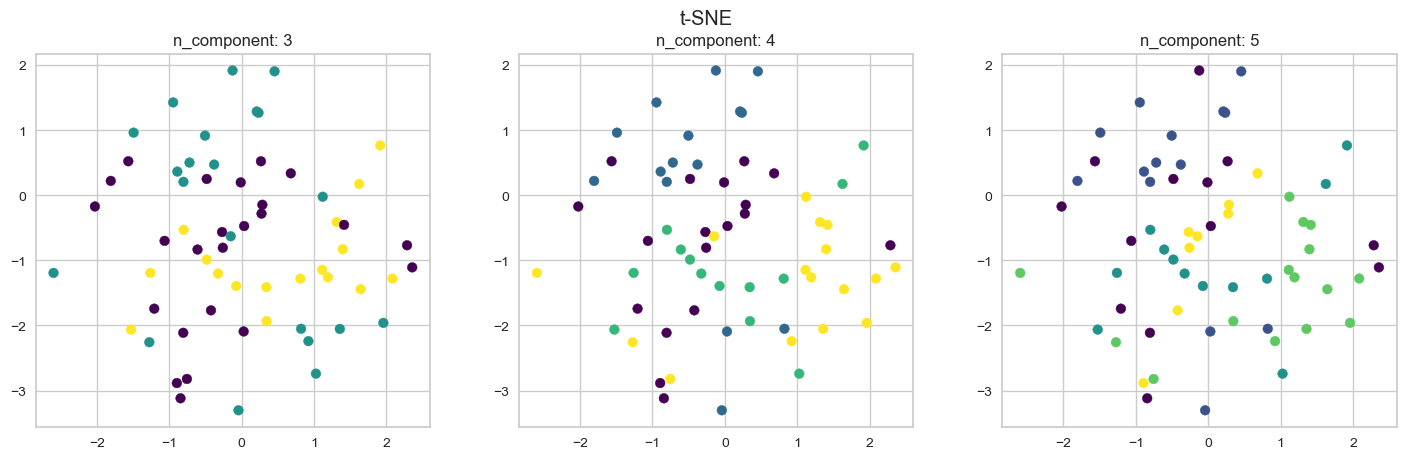

In [213]:
fig_pca = display_clustering(gm_iterations_pca, 3, (15, 5))
fig_pca.suptitle("PCA")

fig_kpca = display_clustering(gm_iterations_kpca, 3, (15, 5))
fig_kpca.suptitle("Kernel PCA")

fig_tsne = display_clustering(gm_iterations_tsne, 3, (15, 5))
fig_tsne.suptitle("t-SNE")

#### Erkenntnisse / Beobachtungen
Laut der [Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) wird bei der Berechnung standardmäßig k-Means als "Initialization Method" genutzt, um u. a. die Gewichtungen der einzelnen Datenpunkte festzulegen. Die interne Nutzung von k-Means zeigt sich auch in dem finalen Clustering, in dem die Cluster stark denen von k-Means ähneln. Aufgrund der einfacheren Nachvollziehbarkeit des k-Means Algorithmus werden die Cluster von k-Means in der weiteren Untersuchung gegenüber denen des GMM vorgezogen.

## 1.5 Hierarchichal Clustering

Das hierarchische Clustering stellt eine weitere Alternative zu den bisherigen Ansätzen dar. Hierbei werden die Datenpunkte entweder ausgehend von einem großen Cluster nach und nach in kleinere Cluster unterteilt (Top-Down) oder ausgehend von einem eigenen Cluster für jedeen Datenpunkt nach und nach zu größeren Clustern zusammengefasst (Bottom-Up). Als Vorteil gegenüber der bisherigen Verfahren können Clusterstrukturen mit beliebiger Form erkannt werden. Weiterhin ist es möglich, durch die Ausgabe der baumartigen Clusterstruktur die Berechnung besser nachvollziehen zu können.

Zur Berechnung muss jedoch entweder die Anzahl der gewünschten Cluster (n_clusters) oder ein Abstandsgrenzwert (distance_threshold) explizit angegeben werden. Analog zum Vorgehen von k-Means kann hierfür die "Elbow-Method" genutzt werden, um mögliche Werte für die Anzahl der Cluster k zu berechnen.

### 1.5.1 Finden von Parametern mit "Elbow-Method"

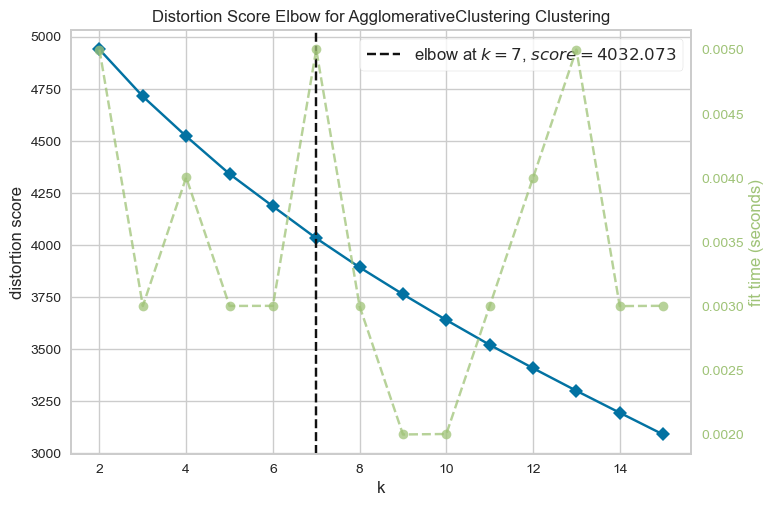

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [215]:
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=15)

visualizer.fit(data_encoded_scaled)
visualizer.show()

#### Erkenntnisse / Beobachtungen
Wie schon bei k-Means nimmt der "Distortion"-Wert bzgl. der Clusteranzahl k tendenziell linear ab, wodurch kein eindeutiger "Elbow" zu erkennen ist. Auch hier erscheint das manuelle Ausprobieren mehrerer Clustergrößen als sinnvoll.

### 1.5.2 Manuelle Suche von Cluster-Parametern

Da die Clusteranzahl für die weitere Untersuchung nicht zu groß werden sollte, wird im Folgenden ausschließlich der Parameter "n_clusters" variiert.

In [216]:
def compute_hc(input_data, evaluation_data, cluster_params_n_clusters):
        hc_iterations = []

        for n_cluster in cluster_params_n_clusters:
                parameter_string = "n_clusters: " + str(n_cluster)

                hc = AgglomerativeClustering(linkage="ward", n_clusters=n_cluster).fit(input_data)
                evaluation_data_copy = evaluation_data.copy()
                evaluation_data_copy["cluster"] = hc.labels_
                hc_iterations.append((parameter_string, evaluation_data_copy))

        return hc_iterations

In [217]:
cluster_params_n_clusters = [3, 4, 5]

hc_iterations_pca = compute_hc(data_encoded_scaled, data_original_reduced_pca, cluster_params_n_clusters)
hc_iterations_kpca = compute_hc(data_encoded_scaled, data_original_reduced_kpca, cluster_params_n_clusters)
hc_iterations_tsne = compute_hc(data_encoded_scaled, data_original_reduced_tsne, cluster_params_n_clusters)

Text(0.5, 0.98, 't-SNE')

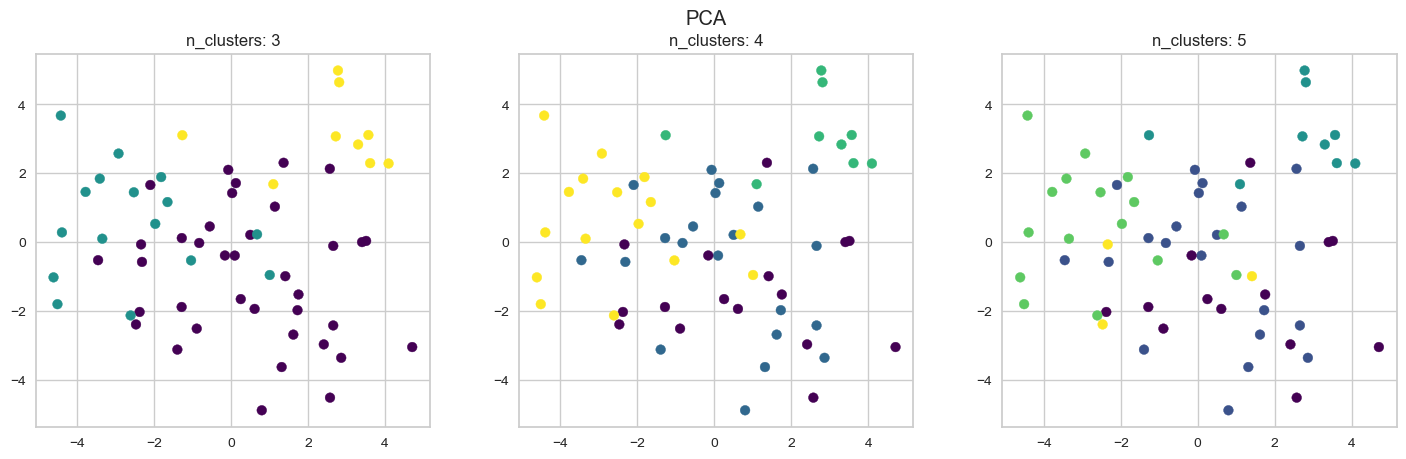

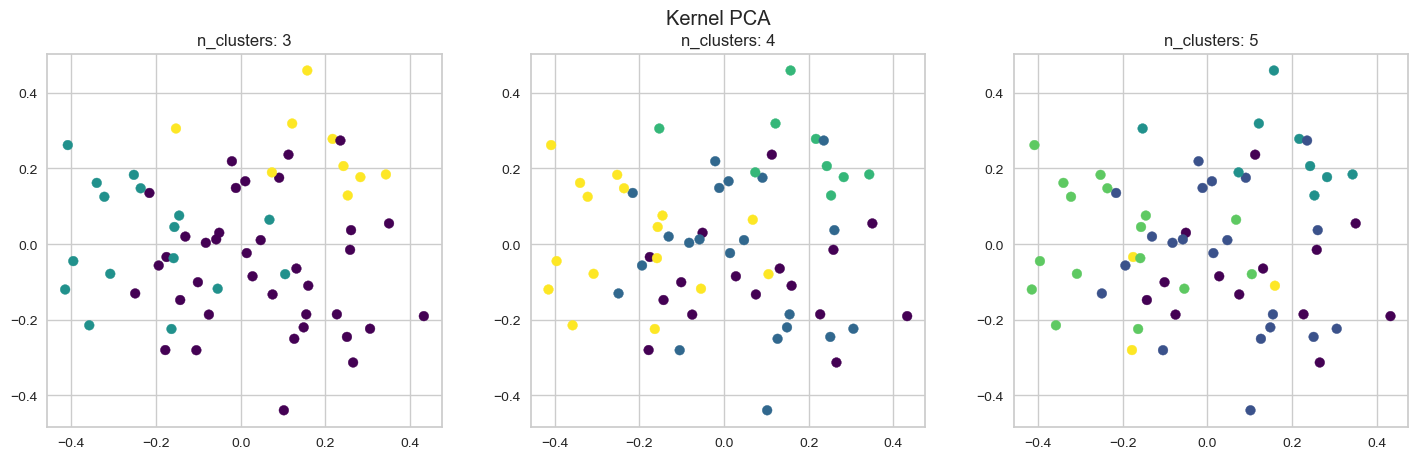

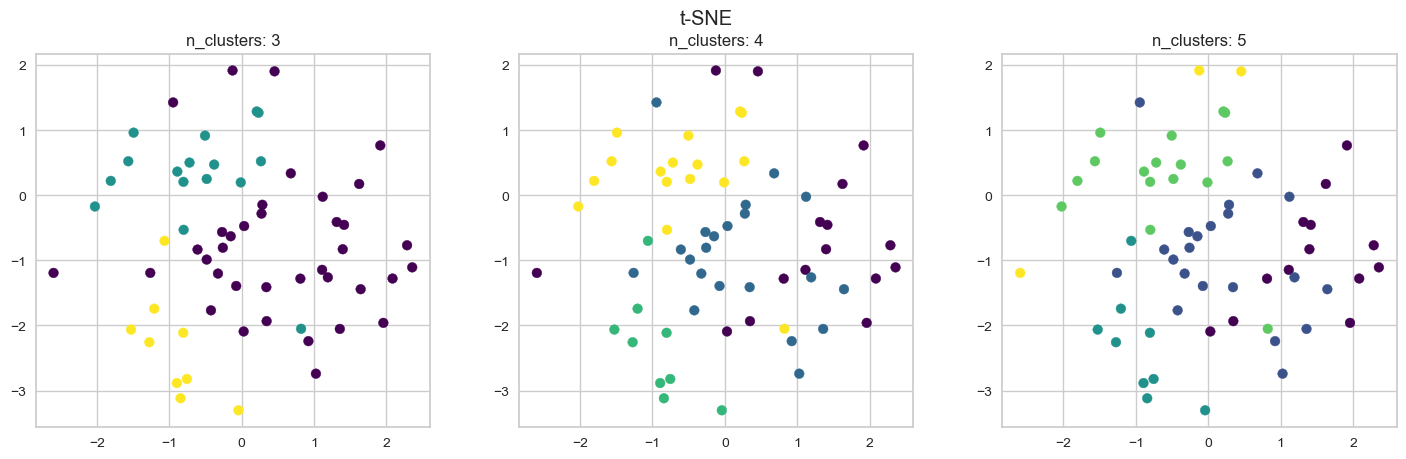

In [218]:
fig_pca = display_clustering(hc_iterations_pca, 3, (15, 5))
fig_pca.suptitle("PCA")

fig_kpca = display_clustering(hc_iterations_kpca, 3, (15, 5))
fig_kpca.suptitle("Kernel PCA")

fig_tsne = display_clustering(hc_iterations_tsne, 3, (15, 5))
fig_tsne.suptitle("t-SNE")

Mithilfe der "Hierarchy"-Bibliothek lässt sich auch das sukzessive Clustering in Form eines Dendograms visualisieren.

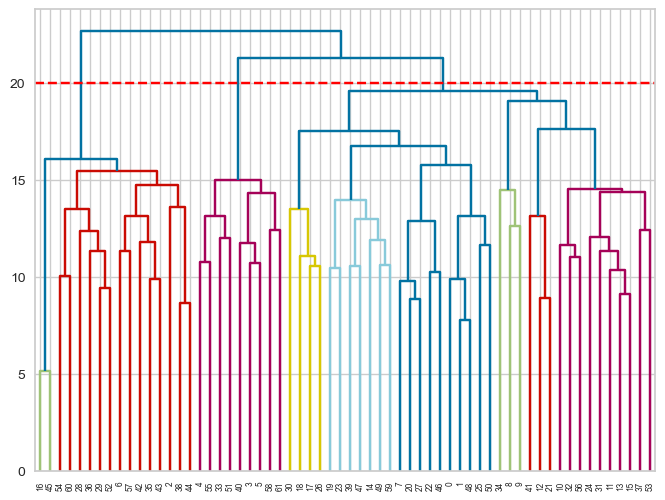

In [219]:
clusters = hierarchy.linkage(data_encoded_scaled, method="ward")
plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)

plt.axhline(20, color='red', linestyle='--'); 

### Ergebnisse / Beobachtungen
In den Plots für (Kernel) PCA scheinen die berechneten Cluster auf den ersten Blick (bei der Darstellung auf den reduzierten Daten) nur losere Cluster zu bilden. Im Gegensatz dazu sind die Cluster für die Darstellung der mit t-SNE reduzierten Daten gut zu erkennen. Auch wenn es einzelne Ausreißer gibt, die intuitiv einem anderen Cluster zugehörig wären, sind in jeder der drei gewählten Clustergrößen eindeutige Strukturen zu erkennen.

Im Dendogramm ist zudem zu erkennen, dass bei einer größeren Anzahl von Cluster vor allem das "rechteste" Cluster weiter aufgeteilt wird (unterhalb der roten Markierung). Auch in den Scatterplots ist dies zu erkennen: So wird das lilane Cluster bei einer höheren Anzahl nach und nach feiner unterteilt. Ob diese feinere Unterteilung sinnhaft ist, lässt sich rein anhand dieser Darstellungen aber nicht entscheiden.

# 2. Durchführen des Clustering auf dimensionsreduzierten Daten

Anstatt die Clustering-Algorithmen auf den originalen Daten auszuführen, wäre es auch denkbar, die Cluster auf den reduzierten Daten zu bilden. Falls die Dimensionsreduzierung die Informationen in den höherdimensionalen Daten gut zusammengefasst haben, würden die so gebildeten Cluster auch Schlüsse auf die ursprünglichen Daten zulassen.

Im Folgenden werden die in Kapitel 1 verwendeten Algorithmen auf die reduzierten Daten angewandt. Da die reduzierten Daten auch für die Visualisierung der Ergebnisse genutzt werden, ist zu erwarten, dass die gebildeten Cluster hier eindeutiger zu erkennen sind.

## 2.1 k-Means

Wie bereits in Kapitel 1.2.1 wird mit der "Elbow-Method" zunächst nach einer geeigneten Anzahl von Clustern gesucht. Exemplarisch wird hier das mit PCA reduzierte Datenset verwendet.

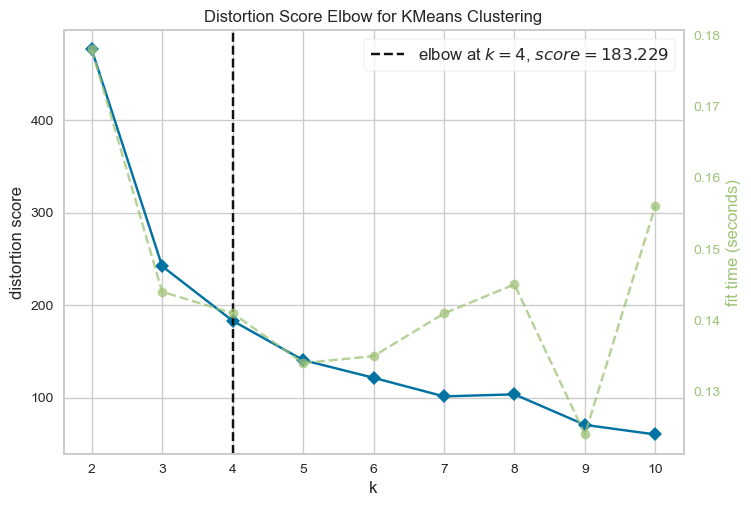

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [220]:
model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=10)

visualizer.fit(data_original_reduced_pca)
visualizer.show()

Bei der Anwendung auf die reduzierten Daten ist der "Elbow" nun deutlich besser zu erkennen. Die vom Algorithmus vorgeschlagene Clustergröße von 4 kann daher als Anhaltspunkt für die weitere Untersuchung genutzt werden. Da k-Means insb. von den zufällig gewählten Startpunkten für die Clusterzentren abhängig ist, werden zudem die umliegenden Clustergrößen wie bereits in Kapitel 1.2.2 untersucht

In [221]:
cluster_params_n_clusters = [3, 4, 5]

kmeans_iterations_pca, kmeans_scores_pca = compute_kmeans(data_original_reduced_pca, data_original_reduced_pca, cluster_params_n_clusters)
kmeans_iterations_kpca, kmeans_scores_kpca = compute_kmeans(data_original_reduced_kpca, data_original_reduced_kpca, cluster_params_n_clusters)
kmeans_iterations_tsne, kmeans_scores_tsne = compute_kmeans(data_original_reduced_tsne, data_original_reduced_tsne, cluster_params_n_clusters)

Text(0.5, 0.98, 't-SNE')

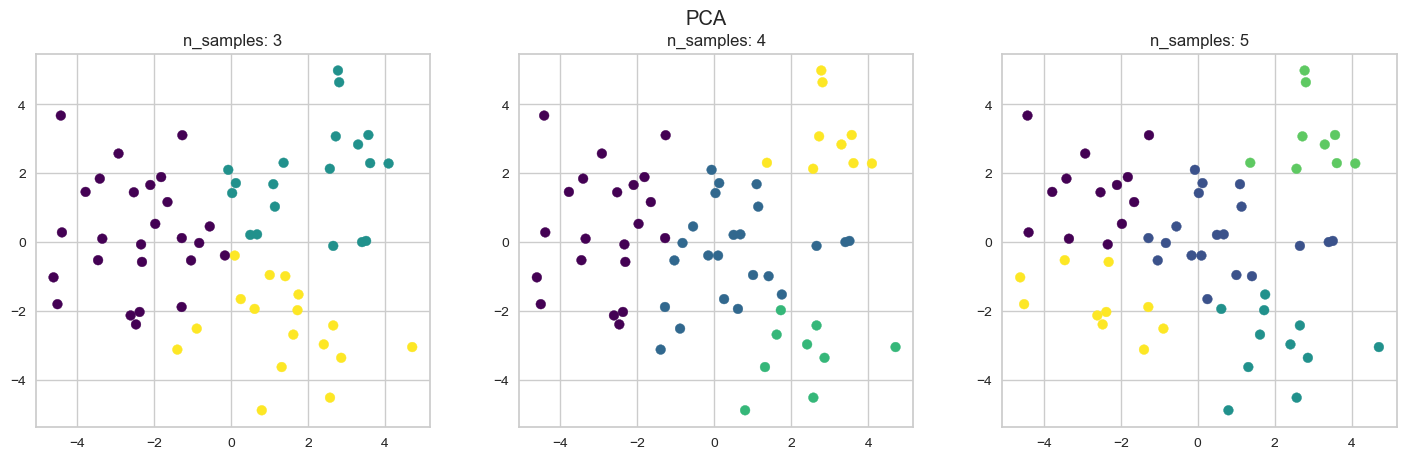

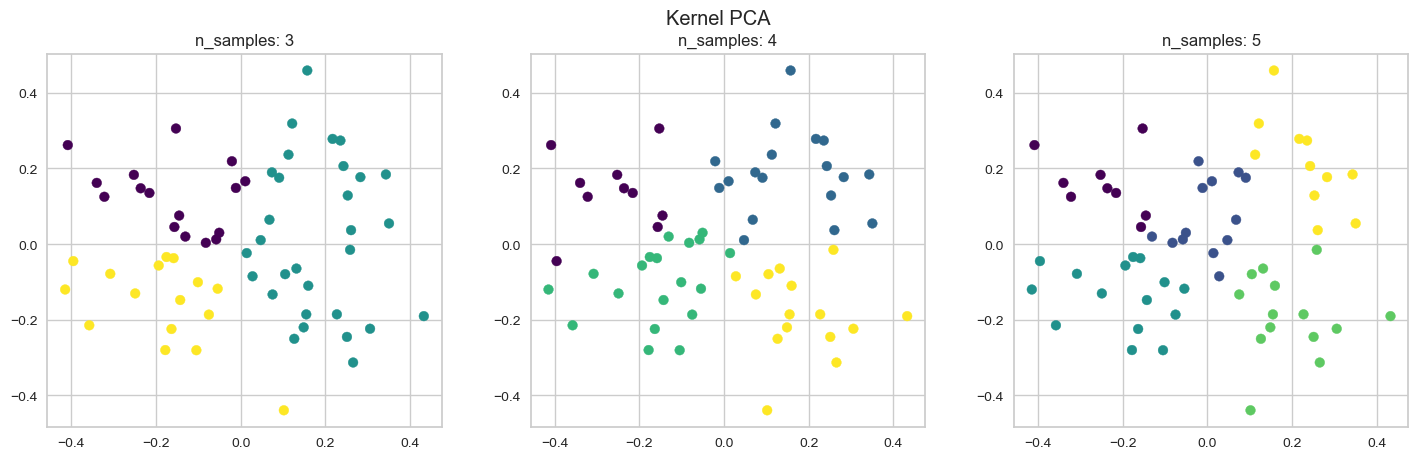

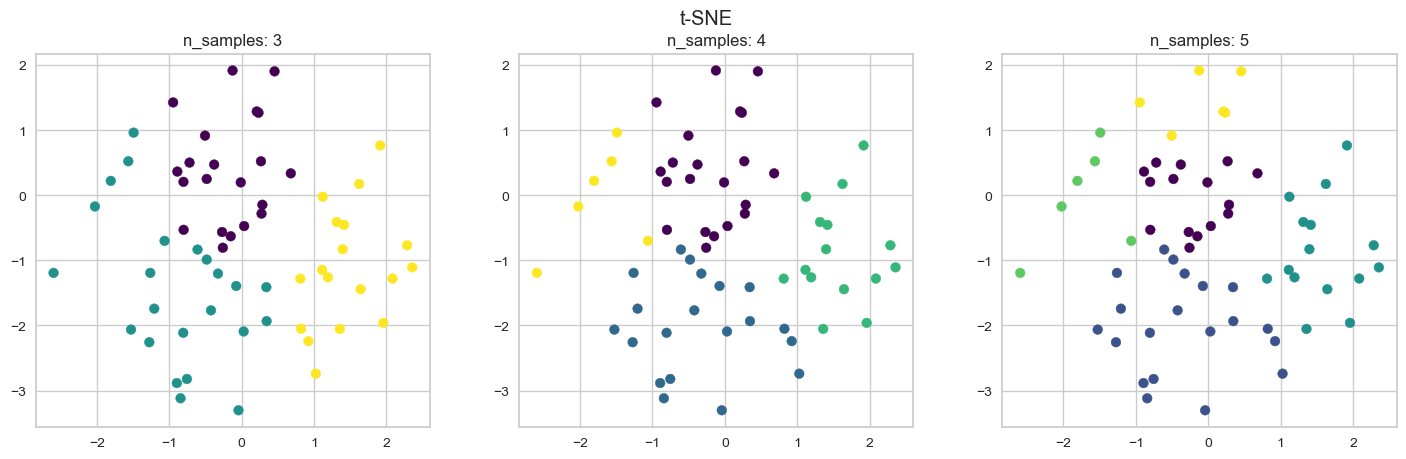

In [222]:
fig_pca = display_clustering(kmeans_iterations_pca, 3, (15, 5))
fig_pca.suptitle("PCA")

fig_kpca = display_clustering(kmeans_iterations_kpca, 3, (15, 5))
fig_kpca.suptitle("Kernel PCA")

fig_tsne = display_clustering(kmeans_iterations_tsne, 3, (15, 5))
fig_tsne.suptitle("t-SNE")

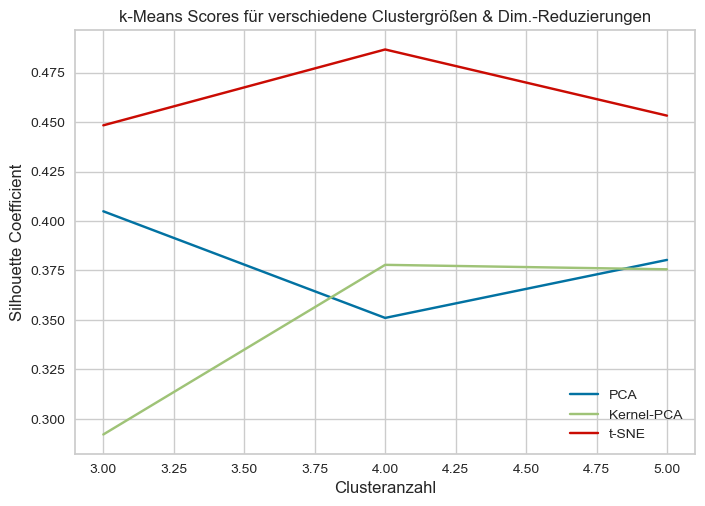

In [223]:
plt.plot(kmeans_scores_pca.n_samples, kmeans_scores_pca.score, label="PCA")
plt.plot(kmeans_scores_kpca.n_samples, kmeans_scores_kpca.score, label="Kernel-PCA")
plt.plot(kmeans_scores_tsne.n_samples, kmeans_scores_tsne.score, label="t-SNE")
plt.xlabel("Clusteranzahl")
plt.ylabel("Silhouette Coefficient")
plt.title("k-Means Scores für verschiedene Clustergrößen & Dim.-Reduzierungen")
plt.legend()
plt.show()

### Ergebnisse / Beobachtungen
Wie erwartet sind in den Plots eindeutige Cluster zu erkennen, auch für die verschiedenen Verfahren zur Dimensionsreduzierung hinweg. Die Eindeutigkeit der Cluster spiegelt sich auch in den "Silhouette Coefficients" wieder, die nun deutlich höher liegen. Das bedeutet jedoch nicht, dass die Cluster die Datenpunkte insgesamt auch besser zuordnen. Hierzu wäre eine nähere Analyse nötig.

## 2.2 DBSCAN

Wie bereits in Kapitel 1.3.1 wird auch hier mit der "Elbow"-Methode nach geeigneten Werten für den "epsilon"-Parameter gesucht. Exemplarisch wird hier das mit PCA reduzierte Datenset verwendet.

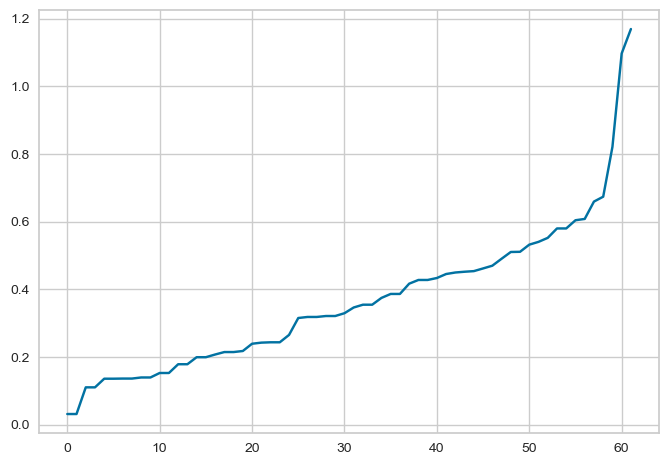

In [224]:
# based on https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(data_original_reduced_tsne)
distances, indices = neighbors_fit.kneighbors(data_original_reduced_tsne)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Bei der Anwendung auf die reduzierten Daten ist der "Elbow" nun deutlich besser zu erkennen. Zudem ist erkennbar, dass die dargestellten "epsilon"-Werte nun um ein vielfaches kleiner sind als bei der Untersuchung in Kapitel 1.3.1. Das spricht dafür, dass die Nachbarschaftslänge deutlich kleiner gewählt werden kann, da die Datenpunkte offenbar näher aneinander liegen.

In [225]:
cluster_params_min_samples = [3, 4, 5, 6]
cluster_params_eps = [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4]

dbscan_iterations_pca = compute_dbscan(data_original_reduced_pca, data_original_reduced_pca, cluster_params_min_samples, cluster_params_eps)
dbscan_iterations_kpca = compute_dbscan(data_original_reduced_kpca, data_original_reduced_kpca, cluster_params_min_samples, cluster_params_eps)
dbscan_iterations_tsne = compute_dbscan(data_original_reduced_tsne, data_original_reduced_tsne, cluster_params_min_samples, cluster_params_eps)

Text(0.5, 1.01, 't-SNE')

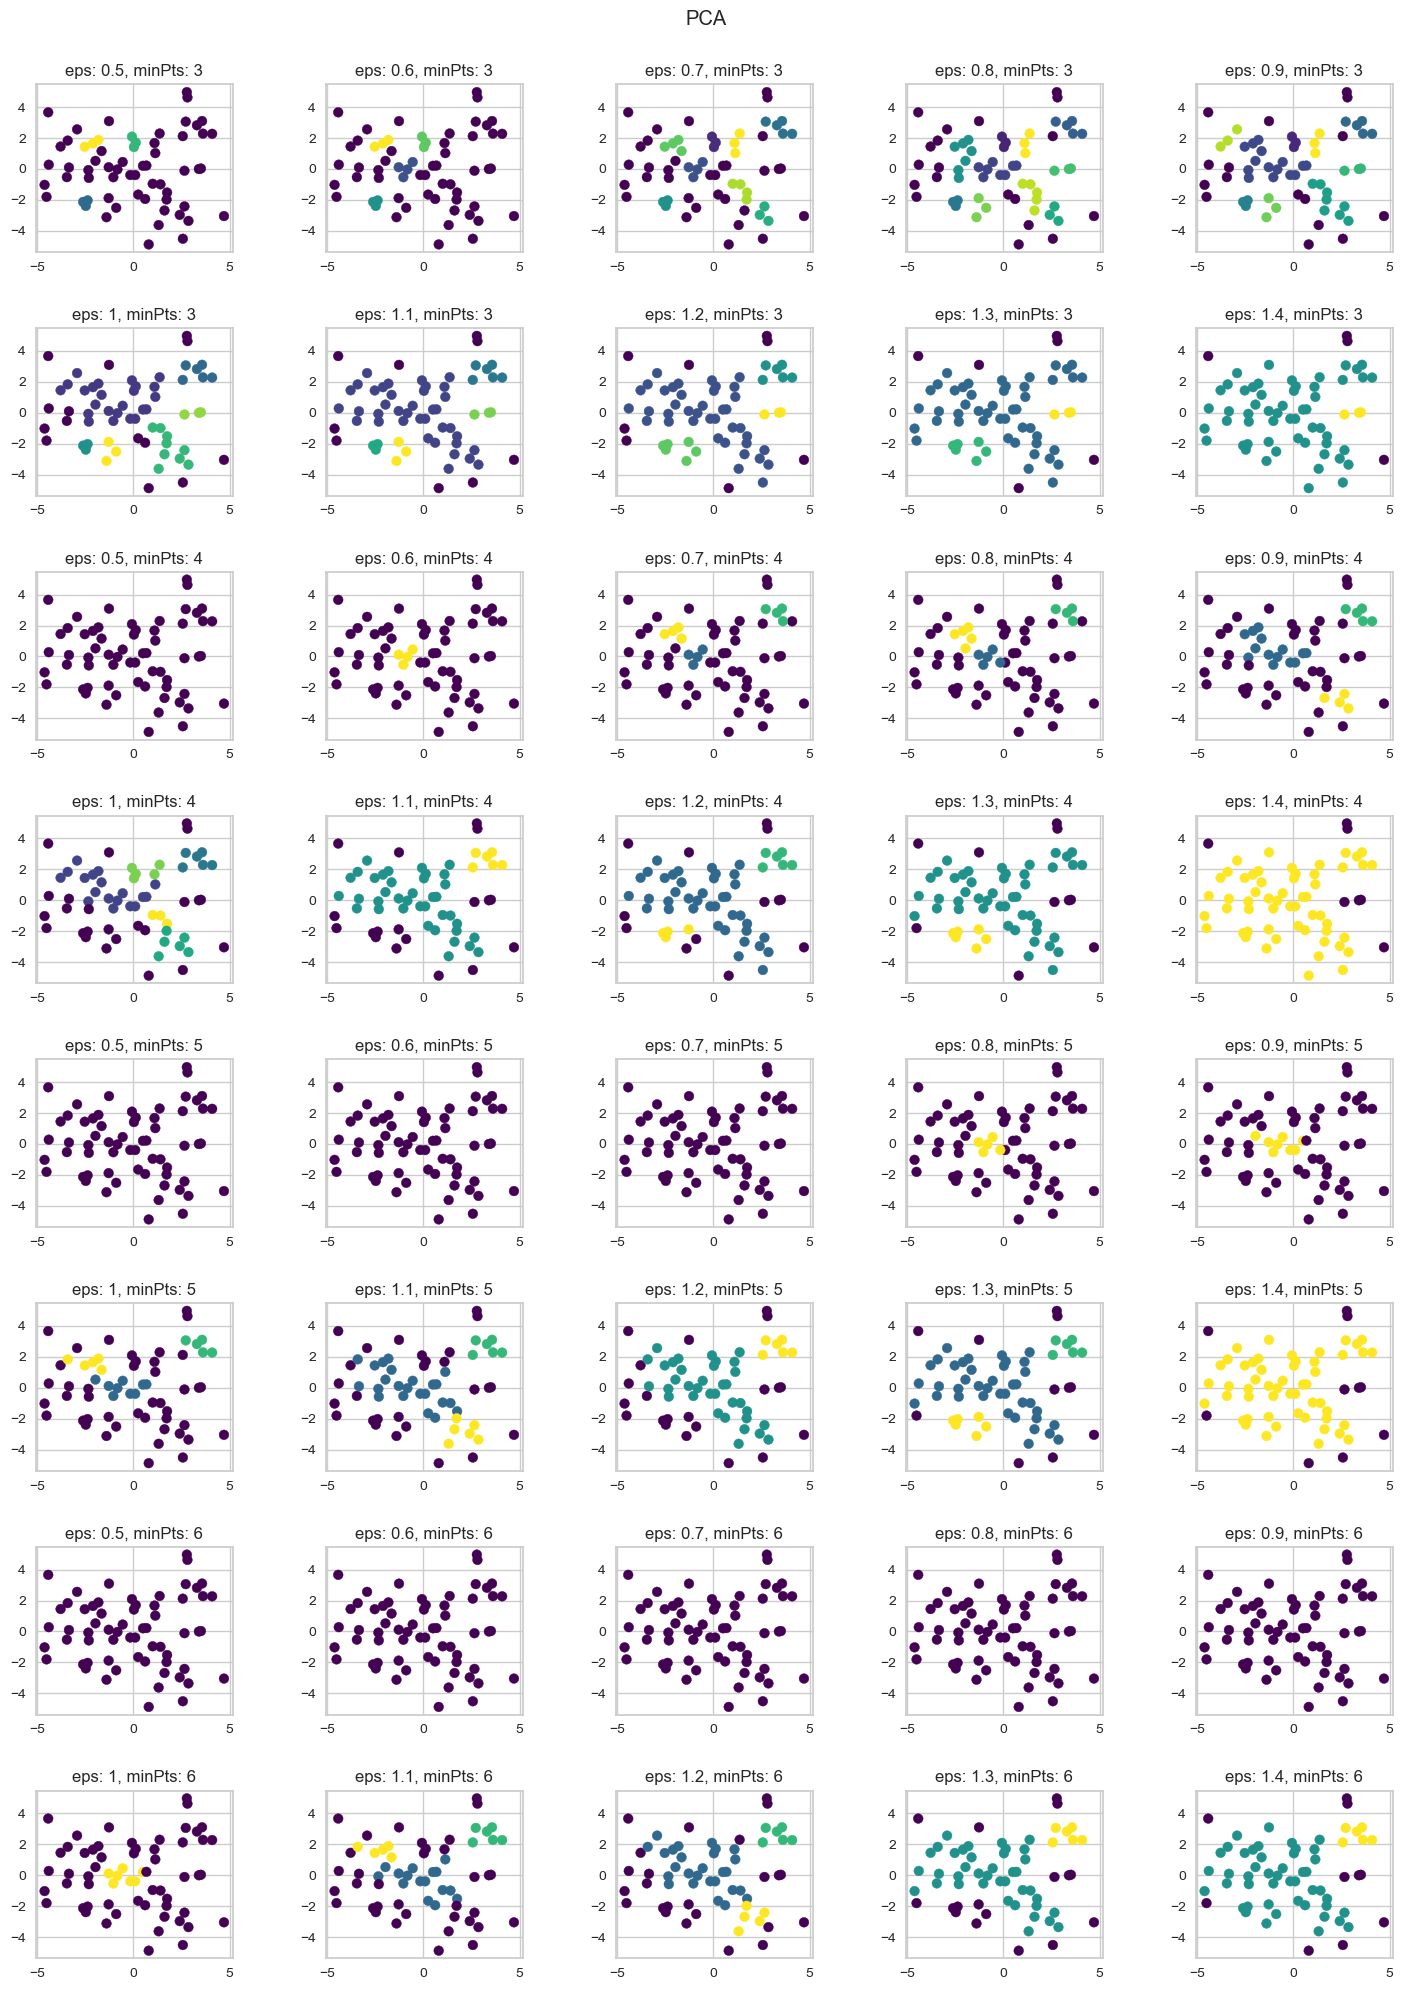

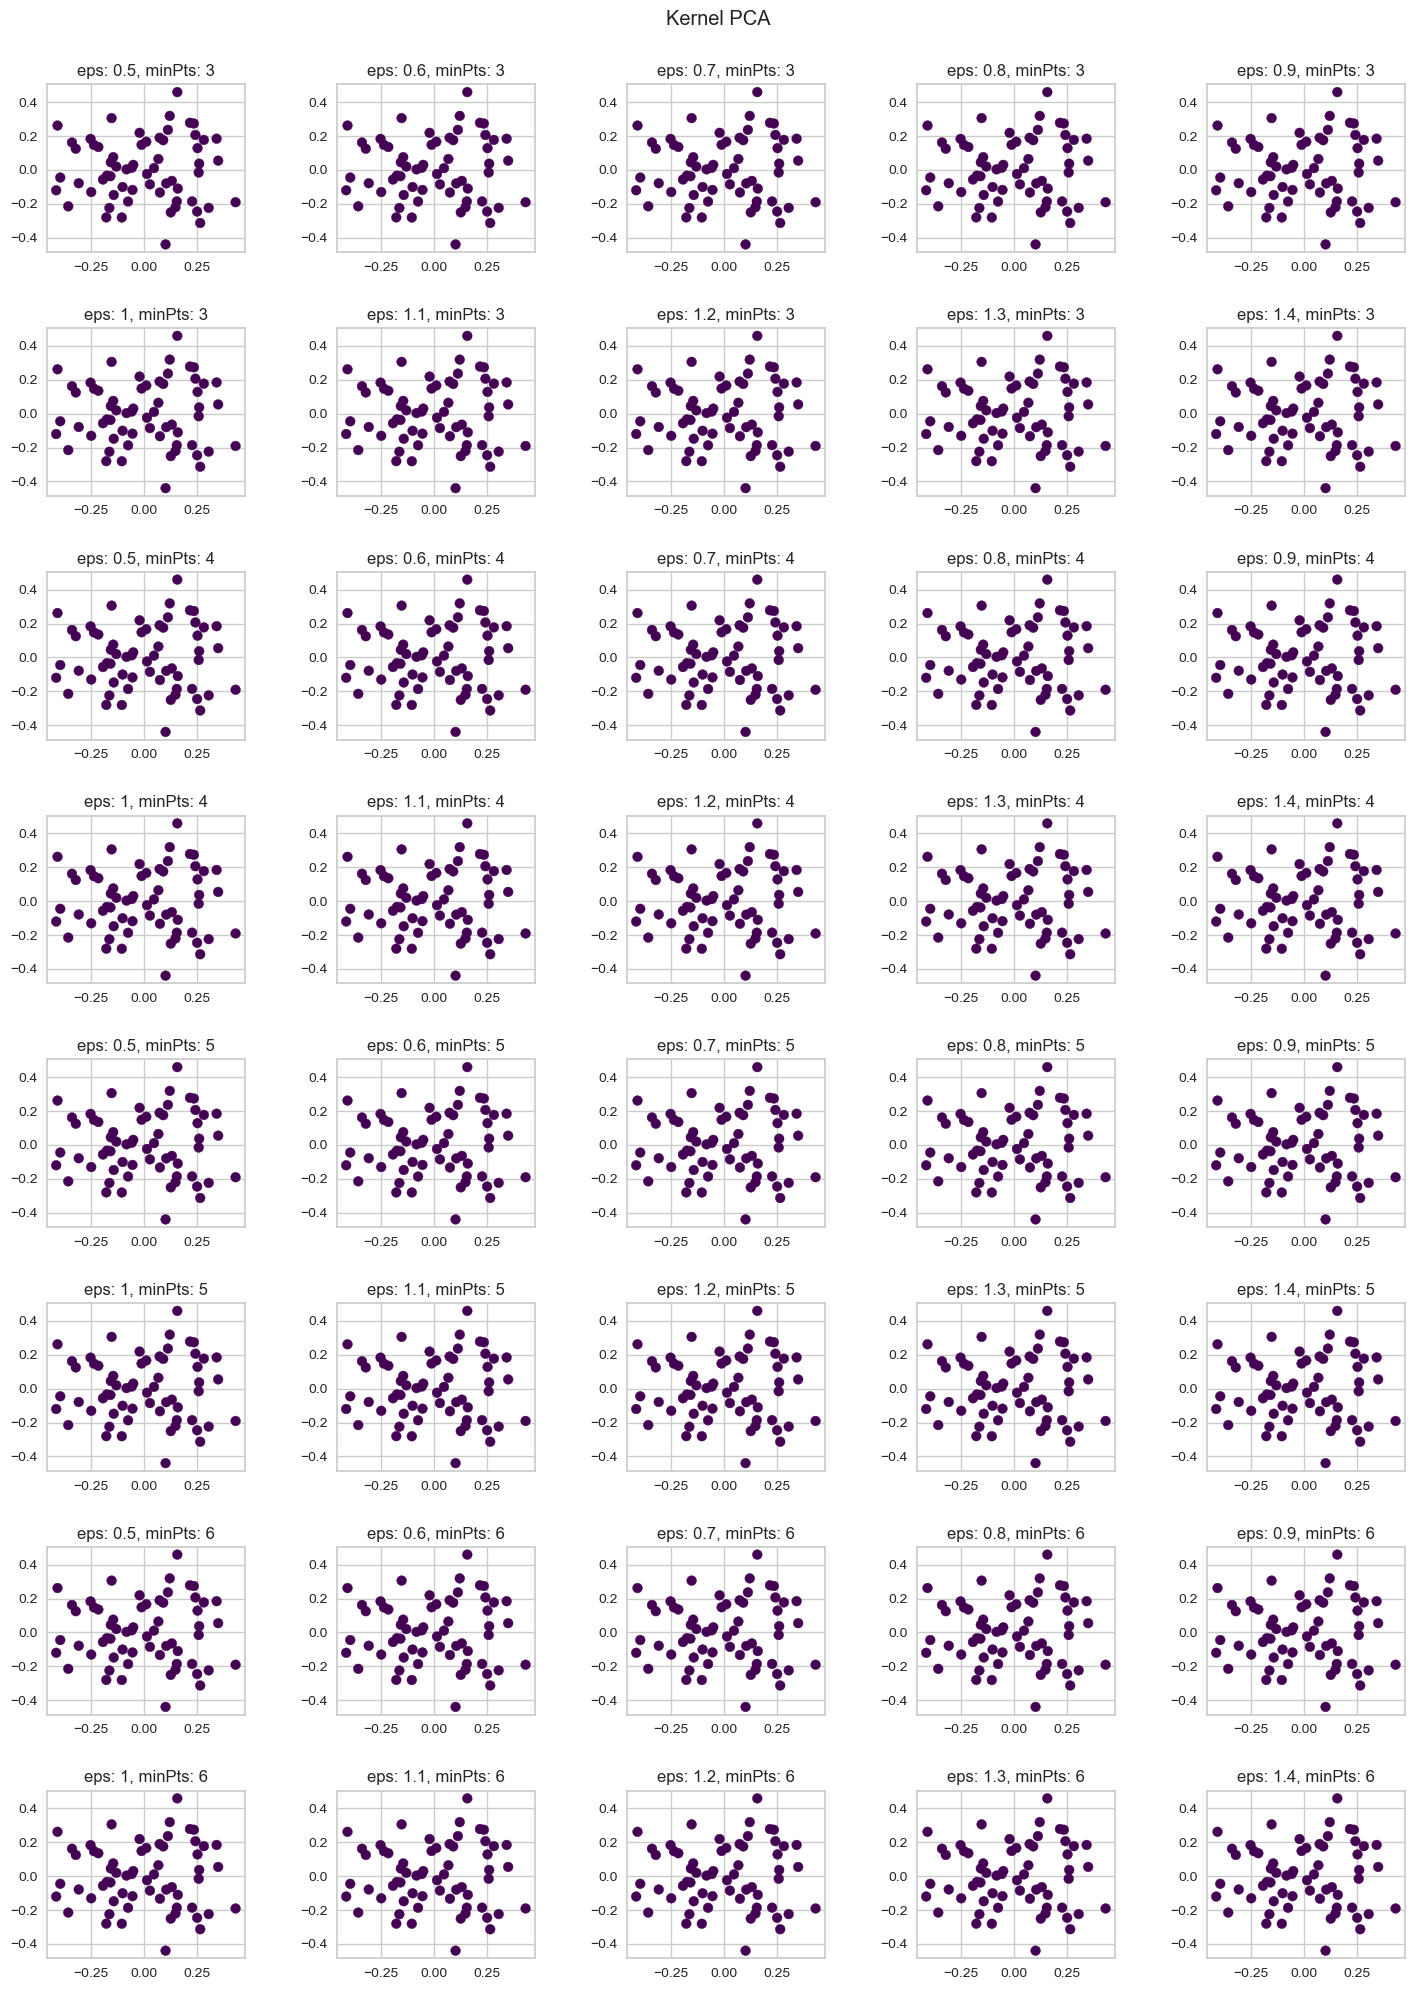

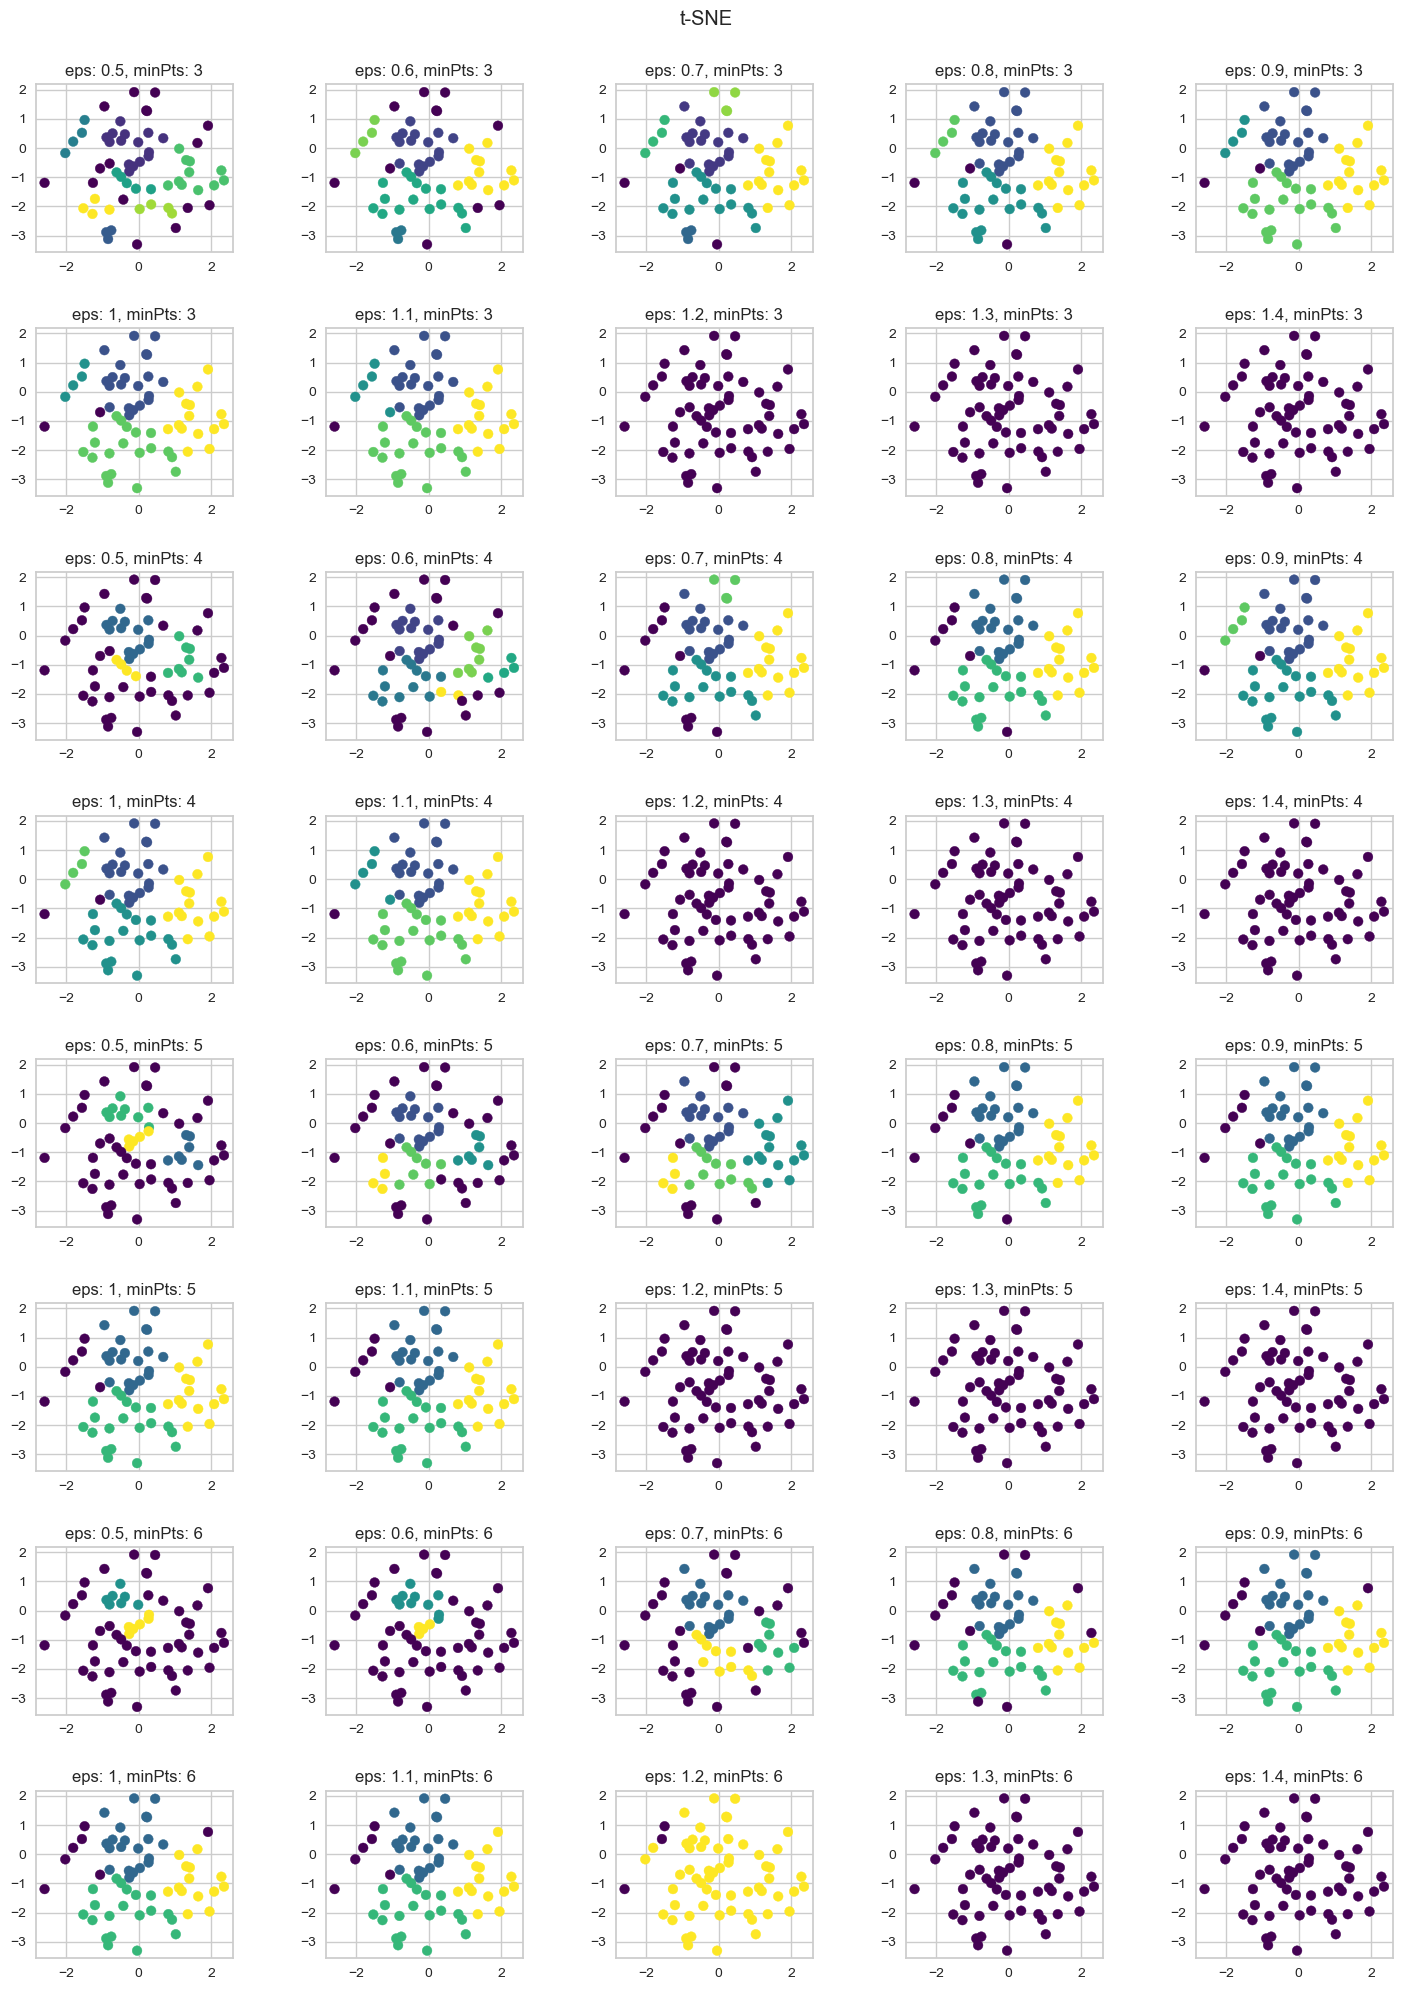

In [226]:
fig_pca = display_clustering(dbscan_iterations_pca, 5, (15, 20))
fig_pca.suptitle("PCA", y=1.01)

fig_kpca = display_clustering(dbscan_iterations_kpca, 5, (15, 20))
fig_kpca.suptitle("Kernel PCA", y=1.01)

fig_tsne = display_clustering(dbscan_iterations_tsne, 5, (15, 20))
fig_tsne.suptitle("t-SNE", y=1.01)

#### Erkenntnisse / Beobachtungen
In vielen der Plots ist der dichtebasiert Ansatz von DBSCAN zu erkennen, der beispielsweise für "minPts"=3 und "eps"=1 für PCA kleinere, dicht zusammenliegende Cluster bildet. Die Form der Cluster in einigen Plots zeigt zudem auch die Möglichkeit von DBSCAN, abstraktere Formen wie z. B. "Kurven" zu erkennen. Insgesamt scheint DBSCAN aber keine zielführenden Cluster zu bilden: Für alle Parameter-Kombinationen und Reduzierungen erkennt DBSCAN offenbar Ausreißer und bildet häufig ein einzelnes, sich von der Mitte der Punkte ausgehendes Cluster. Für die Reduzierung von Kernel PCA scheint DBSCAN sogar gar keine Cluster zu erkennen, was vermutlich aber eher technische Gründe zu haben scheint. Die Gründe hierfür werden vorerst untersucht.

## 2.3 Gaussian Mixture Model

Analog zum Vorgehen in Kapitel 1.4 werden im folgenden Cluster mit GMM auf den reduzierten Daten berechnet.

In [227]:
cluster_params_n_clusters = [3, 4, 5]

gm_iterations_pca = compute_gm(data_original_reduced_pca, data_original_reduced_pca, cluster_params_n_clusters)
gm_iterations_kpca = compute_gm(data_original_reduced_kpca, data_original_reduced_kpca, cluster_params_n_clusters)
gm_iterations_tsne = compute_gm(data_original_reduced_tsne, data_original_reduced_tsne, cluster_params_n_clusters)

Text(0.5, 0.98, 't-SNE')

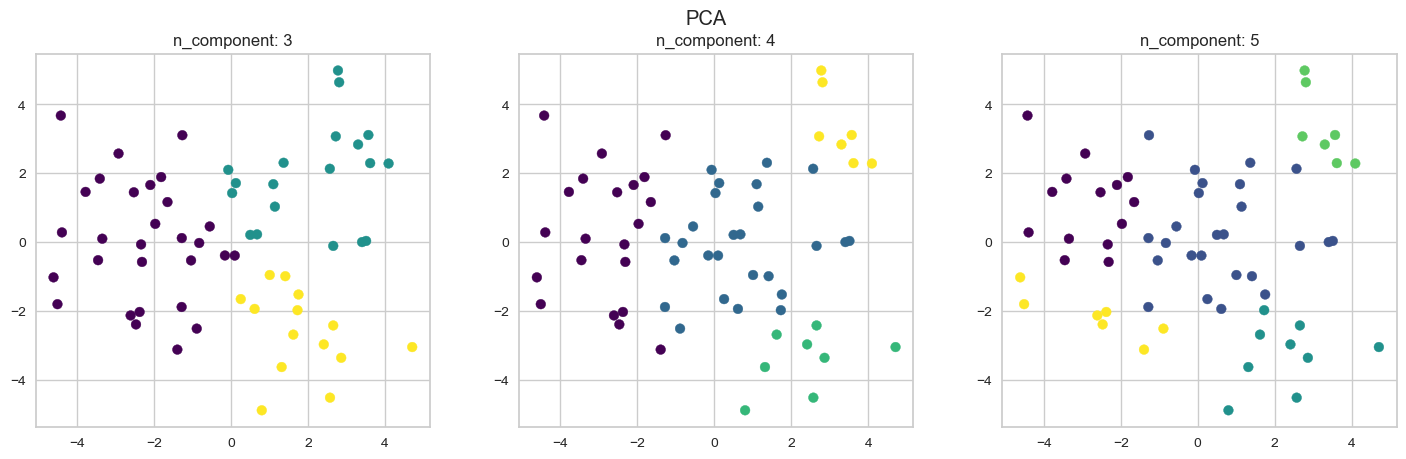

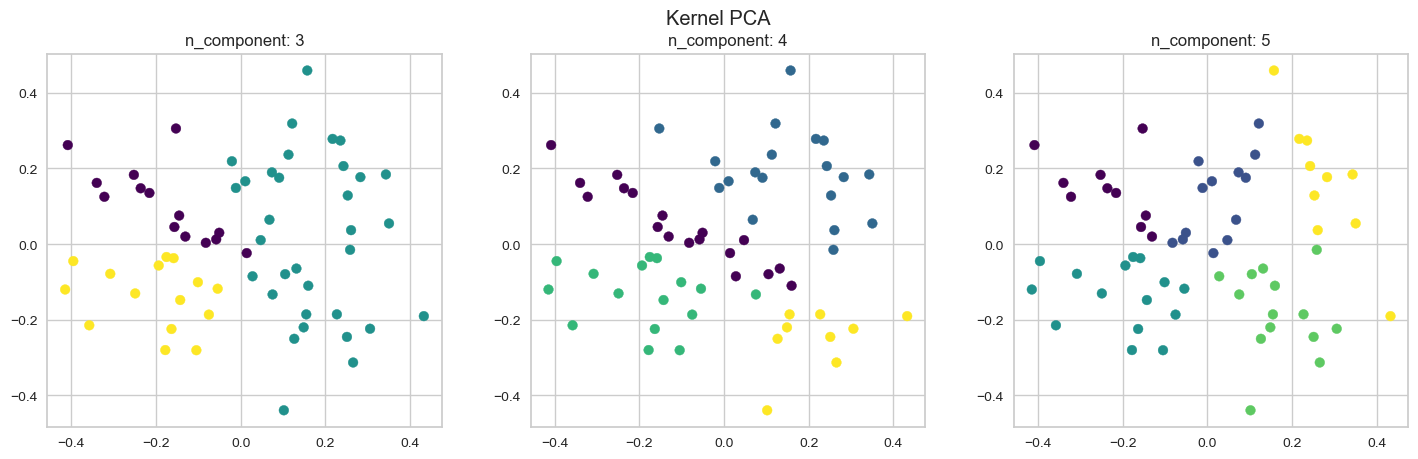

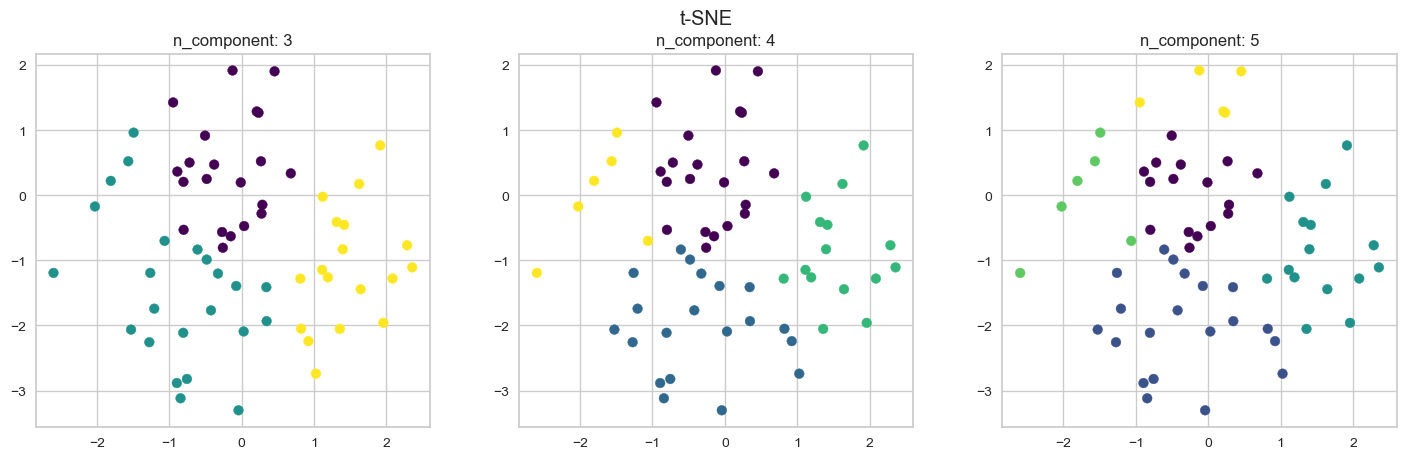

In [228]:
fig_pca = display_clustering(gm_iterations_pca, 3, (15, 5))
fig_pca.suptitle("PCA")

fig_kpca = display_clustering(gm_iterations_kpca, 3, (15, 5))
fig_kpca.suptitle("Kernel PCA")

fig_tsne = display_clustering(gm_iterations_tsne, 3, (15, 5))
fig_tsne.suptitle("t-SNE")

#### Ergebnisse / Beobachtungen
Wie bereits in Kapitel 1.4 stimmen die berechneten Cluster (fast) vollständig mit den von k-Means berechneten Clustern überein und scheinen (basierend auf den Plots) sinnhafte Cluster zu bilden.

## 2.4 Hierarchichal Clustering

Analog zum Vorgehen in Kapitel 1.5 werden im folgenden Cluster mit hierarchischem Clustering auf den reduzierten Daten berechnet.

In [229]:
cluster_params_n_clusters = [3, 4, 5]

hc_iterations_pca = compute_hc(data_original_reduced_pca, data_original_reduced_pca, cluster_params_n_clusters)
hc_iterations_kpca = compute_hc(data_original_reduced_kpca, data_original_reduced_kpca, cluster_params_n_clusters)
hc_iterations_tsne = compute_hc(data_original_reduced_tsne, data_original_reduced_tsne, cluster_params_n_clusters)

Text(0.5, 0.98, 't-SNE')

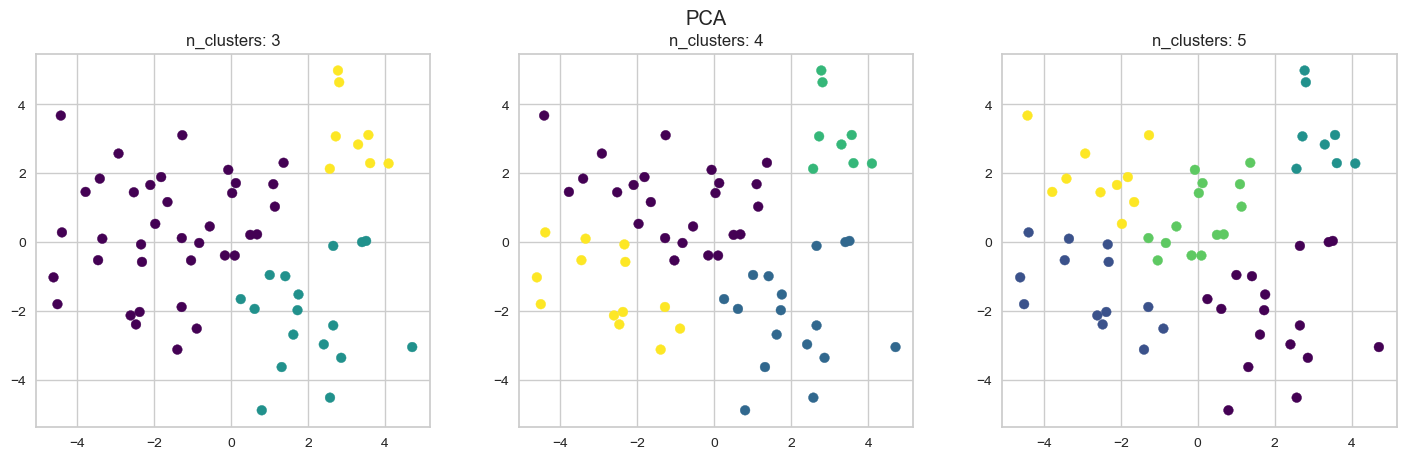

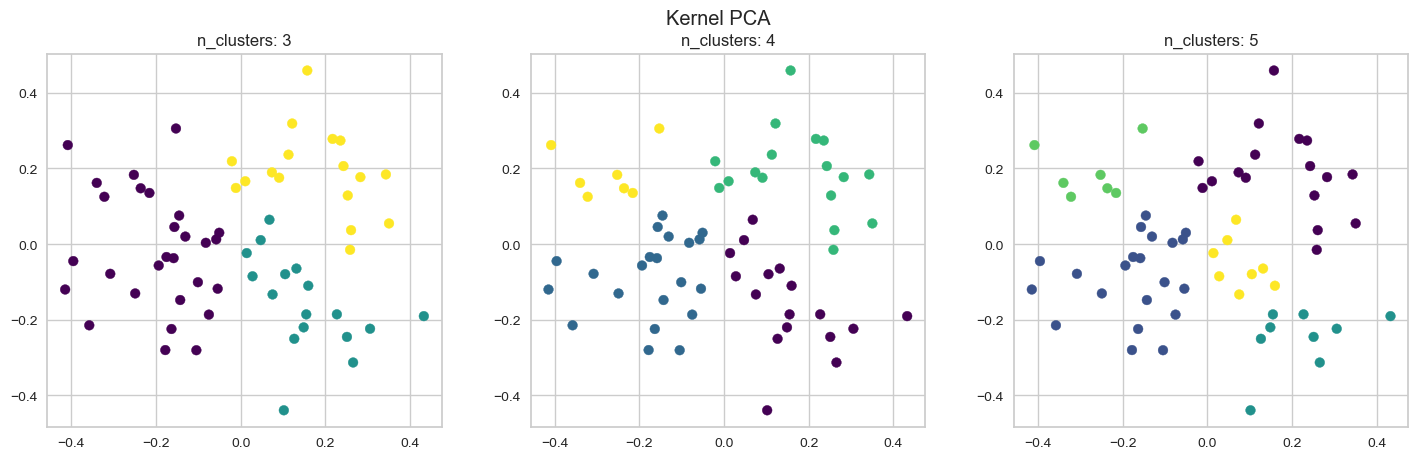

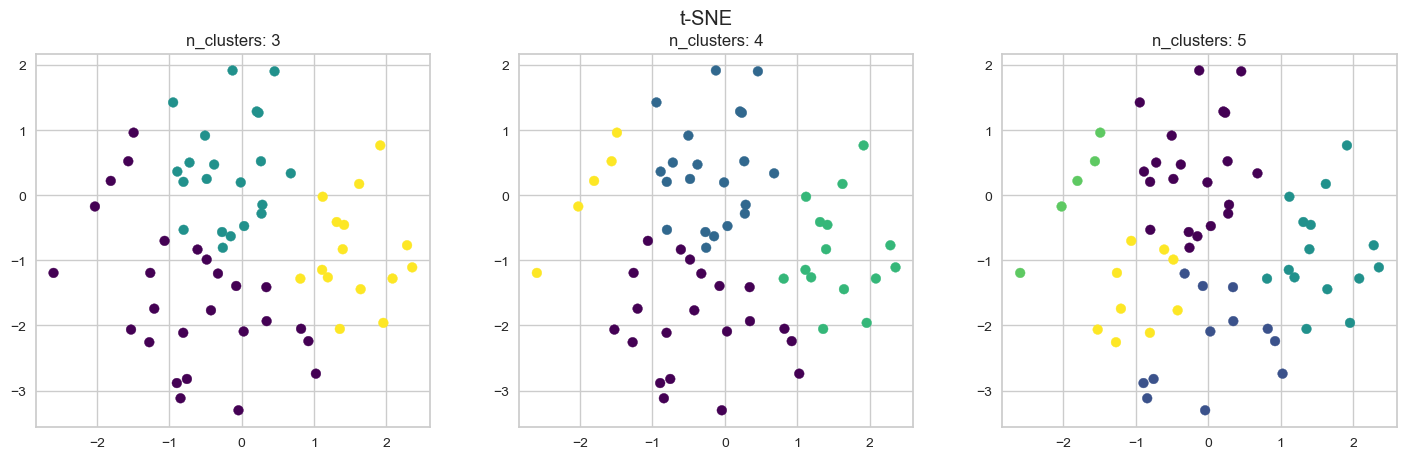

In [230]:
fig_pca = display_clustering(hc_iterations_pca, 3, (15, 5))
fig_pca.suptitle("PCA")

fig_kpca = display_clustering(hc_iterations_kpca, 3, (15, 5))
fig_kpca.suptitle("Kernel PCA")

fig_tsne = display_clustering(hc_iterations_tsne, 3, (15, 5))
fig_tsne.suptitle("t-SNE")

Mithilfe der "Hierarchy"-Bibliothek lassen sich auch hier die Aufbauten der Clustering in Form von Dendogrammen visualisieren.

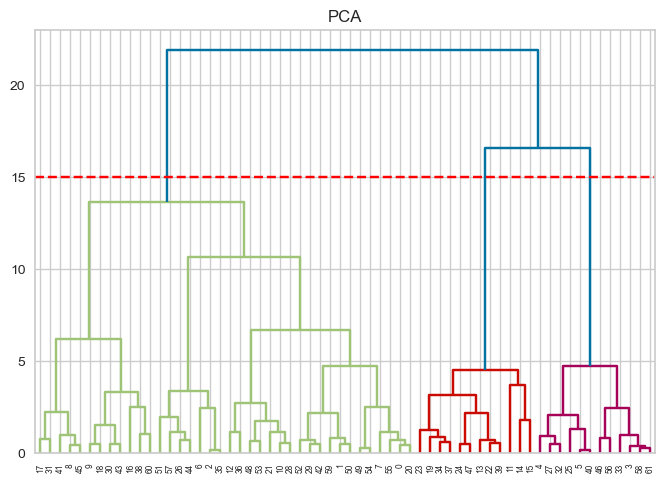

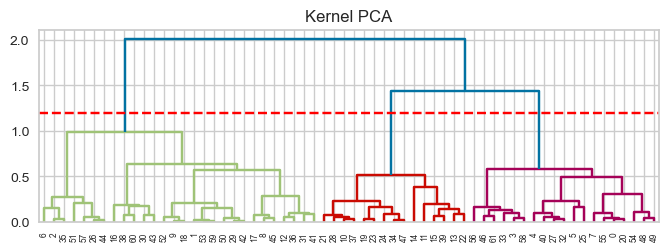

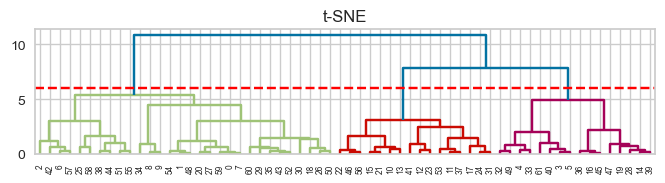

In [159]:
clusters_pca = hierarchy.linkage(data_original_reduced_pca, method="ward")
clusters_kpca = hierarchy.linkage(data_original_reduced_kpca, method="ward")
clusters_tsne = hierarchy.linkage(data_original_reduced_tsne, method="ward")

plt.figure(3)

plt.subplot(1, 1, 1)
plt.subplot(1, 1, 1).set_title("PCA")
dendrogram_pca = hierarchy.dendrogram(clusters_pca)
plt.axhline(15, color='red', linestyle='--'); 
plt.show()

plt.subplot(2, 1, 2)
plt.subplot(2, 1, 2).set_title("Kernel PCA")
dendrogram_kpca = hierarchy.dendrogram(clusters_kpca)
plt.axhline(1.2, color='red', linestyle='--'); 
plt.show() 

plt.subplot(3, 1, 3)
plt.subplot(3, 1, 3).set_title("t-SNE")
dendrogram_tsne = hierarchy.dendrogram(clusters_tsne)
plt.axhline(6, color='red', linestyle='--'); 
plt.show()

### Ergebnisse / Beobachtungen
Das hierarchische Clustering scheint auf den reduzierten Daten gute Ergebnisse zu liefern. Interessant ist hierbei die sukzessive Aufteilung der Cluster. So wird für alle Reduzierungen  relativ schnell ein großes Cluster gebildet. Der Verlauf der Auftrennung ist auch in den Plots zu erkennen: Während für PCA das lilane Cluster nach und nach aufgetrennt wird, werden z. B. bei t-SNE verschiedene Cluster aufgetrennt, genau wie in dem Dendogramm zu sehen ist.

# 3. Nähere Untersuchung des berechneten Cluster

Wie bereits in der bisherigen Untersuchung herausgestellt, können die durch die Algorithmen gebildeten Cluster allein über die Darstellung der reduzierten Daten nicht auf ihre Aussagekraft hin bewertet werden. Daher werden im Folgenden einzelne Feature(gruppen) anhand ihrer zugeordneten Cluster überprüft.

Aus der Vielzahl gebildeter Cluster werden zwei Clusterings zur Auswahl gestellt, die auf den reduzierten Daten die optisch besten Ergebnisse geliefert haben: k-Means und das hierarchische Clustering. Hierbei werden jeweils die aus Kapitel 1 berechneten Clusterings genutzt, die auf den Ursprungsdaten berechnet wurden. Die Hoffnung ist dabei, dass die Clustering eher Aussagen über einzelne Ursprungsfeatures zulassen, da diese auch der Berechnung zugrunde liegen.

In [298]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto').fit(data_encoded_scaled)
data_original_reduced_pca_kmeans = data_original_reduced_pca.copy()
data_original_reduced_pca_kmeans["Cluster"] = kmeans.labels_

hc = AgglomerativeClustering(linkage="ward", n_clusters=3).fit(data_encoded_scaled)
data_original_reduced_pca_hc = data_original_reduced_tsne.copy()
data_original_reduced_pca_hc["Cluster"] = hc.labels_

<Axes: title={'center': 'Hierarchichal Clustering mit Darstellung über die t-SNE-Reduktion'}, xlabel='Hyperparameter1', ylabel='Hyperparameter2'>

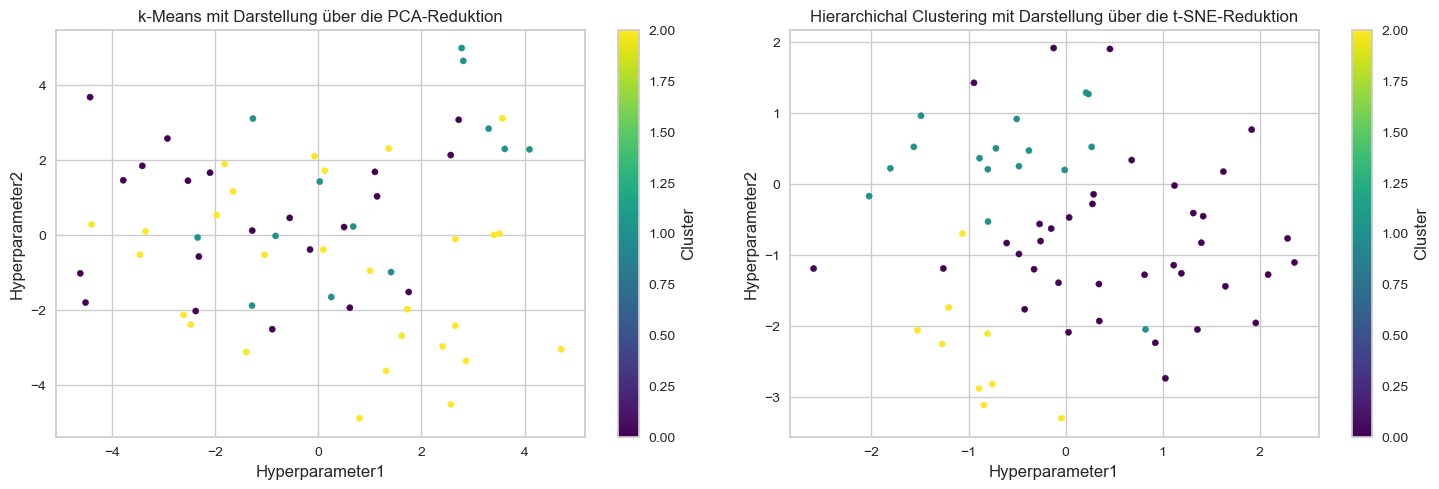

In [299]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
fig.tight_layout(pad=2)

data_original_reduced_pca_kmeans.plot.scatter(ax=axes[0], x="Hyperparameter1", y="Hyperparameter2", c="Cluster", title="k-Means mit Darstellung über die PCA-Reduktion",  cmap="viridis")
data_original_reduced_pca_hc.plot.scatter(ax=axes[1], x="Hyperparameter1", y="Hyperparameter2", c="Cluster", title="Hierarchichal Clustering mit Darstellung über die t-SNE-Reduktion", cmap="viridis")

Im direkten Vergleich ist erkennbar, dass das hierarchische Clustering für die gewählte Reduktion deutlich erkennbarere Cluster bildet. An dieser Stelle zeigt sich jedoch wieder, dass es weder für die Dimensionsreduzierung noch für das Clustering eindeutig "richtige" Ergebnisse gibt: Je nach Kombination verschiedener Verfahren können augenscheinlich "schlechte" Berechnungen vielversprechend wirken und vice verca.

Auch wenn das offenbar gute Clustering des hierarchischen Clusterings auf der t-SNE-Reduktion keineswegs ein Indiz für dessen "Richtigkeit" sein muss, soll dieses Modell für die weitere Untersuchung verwendet werden. Dabei ist das Ziel, ein Clustering gefunden zu haben, dass sowohl für einzelne Features der Ausgangsdaten Aussagen treffen kann, und gleichzeitig in den reduzierten Daten visuell sichtbar wird.

In [300]:
cluster_labels = hc.labels_

data_encoded_clustered = data_encoded.copy()
data_encoded_clustered["Cluster"] = cluster_labels

In [ ]:
tsne_hc_cluster = data_original_reduced_tsne_hc.Cluster
%store tsne_hc_cluster 

## 3.1 Untersuchung anhand korrelierender Features

Wie in der Korrelationsanalyse deutlich wurde, existieren einige Features, die zumindest messbar miteinander korrelieren. Im Optimalfall wurden diese Korrelationen von dem Clustering-Algorithmus erkannt und beachtet, sodass die Zuteilung der Datenpunkte für die korrelierenden Features ähnlich ist. Überprüft wird die Zuteilung durch die gleichzeitige Darstellung beider Features sowie der Zuteilung zum Cluster in einem Stripplot.

Zunächst wird die Feature-Kombination aus dem Interesse für darstellende und bildende Künste untersucht, die in der Korrelationsanalyse den höchsten Zusammenhang aufwies.

<Axes: xlabel='Cluster', ylabel='Wie sehr interessierst du dich für darstellende Künste\nwie Schauspiel, Tanz oder Gesang?'>

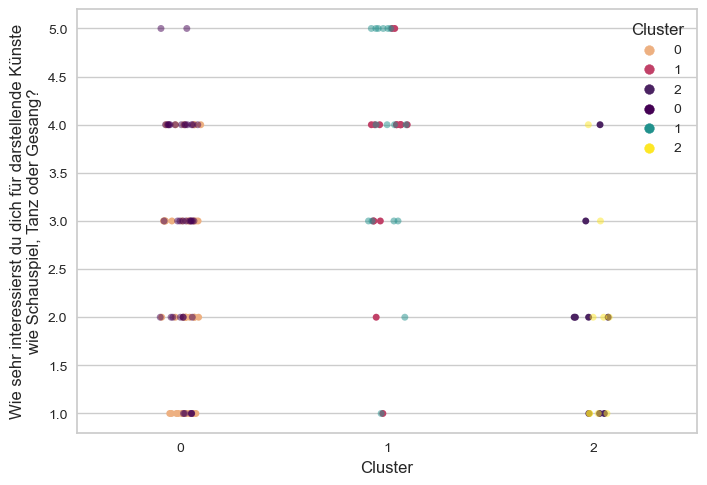

In [301]:
sb.stripplot(data=data_encoded_clustered, x='Cluster', y=columns.schauspiel, hue='Cluster', palette="flare")
sb.stripplot(data=data_encoded_clustered, x='Cluster', y=columns.malen, hue='Cluster', palette="viridis", alpha=0.5)

Wie zu erkennen ist, überschneiden sich die farblich getrennten Datenpunkte (die die Clusterzuteilung für die zwei Features darstellen) weitestgehend. Somit lässt sich feststellen, dass die Korrelation zumindest grundsätzlich bei der Clusterzuteilung beachtet wurde.

Dabei lässt sich weiterhin erkennen, dass die Personen im Cluster 2 insgesamt ein niedrigeres Interesse an Kunst zu scheinen haben, während im Cluster 1 einige Personen mit sehr hohem Interesse zu finden sind. Im Cluster 0 sind sowohl interessierte als auch desinteressierte Personen vorhanden, was auch an der erhöhten Menge von Datenpunkten im insgesamt größeren Cluster liegen kann.

<Axes: xlabel='Cluster', ylabel='Prokrastinierst du, wenn du lernen müsstest?'>

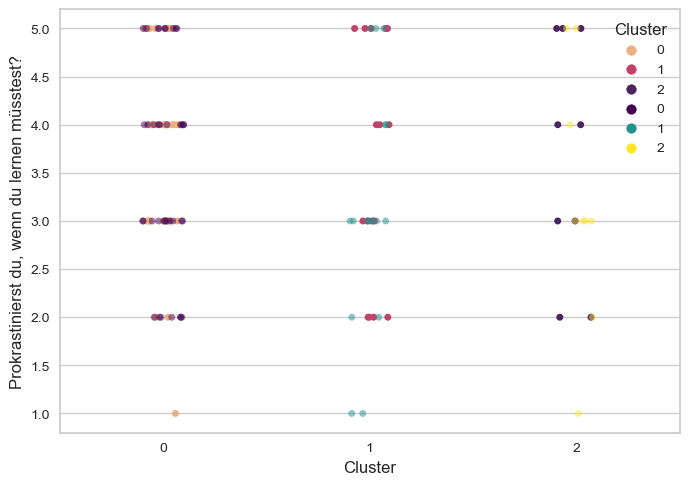

In [302]:
sb.stripplot(data=data_encoded_clustered, x='Cluster', y=columns.prokrastinieren, hue='Cluster', palette="flare")
sb.stripplot(data=data_encoded_clustered, x='Cluster', y=columns.letzter_druecker, hue='Cluster', palette="viridis", alpha=0.5)

Eine weitere Korrelation bestand im Verhalten des Prokrastinierens und Abgabeverhalten. Auch hier lässt sich erkennen, dass die Datenpunkte innerhalb der Cluster für die zwei Features ähnlich verteilt sind. Auch wenn dies für eine sinnhafte Clusterzuteilung spricht, lassen sich aufgrund der eher gleichmäßigen Verteilung der Datenpunkte entlang der Features jedoch hier keine genauen Aussagen über verschiedene Verhaltensweisen zwischen den Clustern erkennen.

<Axes: xlabel='Cluster', ylabel='Wie sehr interessierst du dich für bildende Kunst wie\nMalen, Zeichnen oder Fotografie?'>

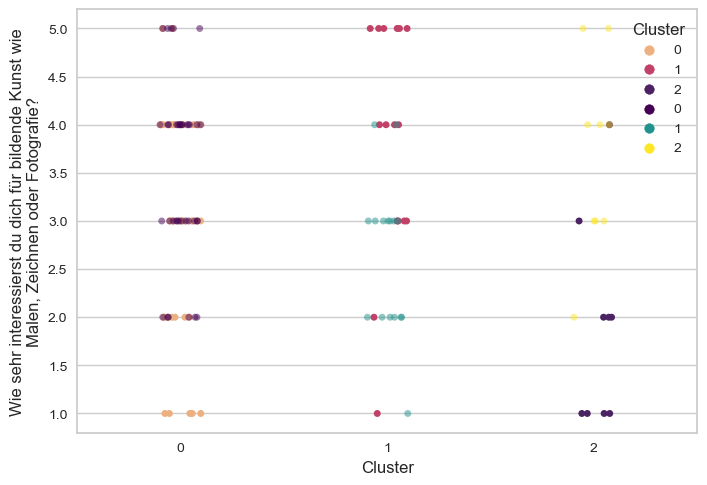

In [303]:
sb.stripplot(data=data_encoded_clustered, x='Cluster', y=columns.malen, hue='Cluster', palette="flare")
sb.stripplot(data=data_encoded_clustered, x='Cluster', y=columns.sportlichkeit, hue='Cluster', palette="viridis", alpha=0.5)

Neben den positiven Korrelationen sind in der Analyse jedoch auch negative Korrelationen aufgefallen, so zum Beispiel zwischen dem Interesse an bildenden Künsten und der Einschätzung der Sportlichkeit. Hier ist zumindest in den Clustern 1 und 2 zu erkennen, dass die Datenpunkte für die zwei Features eher gegensätzlich verteilt zu sein. Auch das spricht dafür, dass die Bildung der Cluster grundsätzlich nachvollziehbar ist, und den Datenpunkten der Cluster gemeinsame Eigenschaften zugeschrieben werden können.

## 3.2 Untersuchung anhand von Themenbereichen

Wie in der Untersuchung der Cluster auf (negativ) korrelierende Feature deutlich wurde, scheinen die Datenpunkte der Cluster womöglich ähnliche Verhaltensweisen aufzuweisen. Für die nähere Untersuchung können im Folgenden die in der Dimensionsreduzierung festgelegten Themenbereiche genutzt werden, um zu überprüfen, ob sich die Cluster anhand dieser unterscheiden lassen.

Für die Berechnung der Werte für die Themenbereiche wurden in der Dimensionsreduzierung verschiedene Verfahren genutzt. Bei der Nutzung von Kernel PCA war zu erkennen, dass die Datenpunkt für die Werte des Themenbereichs "Demographie" streifenartige Strukturen zu bilden scheinen, und die Daten vor allem nach Studiengängen getrennt haben. Um diese Beobachtung weiter zu untersuchen, wird das Datenset genutzt, das auf der Berechnung der Themenfelder mithilfe von Kernel PCA beruht.

In [304]:
data_topics = data_topics_reduced_kpca.copy()
data_topics["Cluster"] = cluster_labels
data_topics

Demographie  Aktivität  Kreativität  Wissenschaft  Soziales  \
0     -0.587912   0.113878    -0.171371     -0.585440 -0.065196   
1     -0.581340  -0.012626    -0.252510      0.571401 -0.064866   
2     -0.537711  -0.167822    -0.207035     -0.337822 -0.356242   
3     -0.503817  -0.162075     0.546720     -0.047036  0.134251   
4     -0.339019   0.262010     0.449739     -0.366644  0.054083   
..          ...        ...          ...           ...       ...   
57    -0.581340  -0.184468    -0.392386     -0.399189  0.235023   
58     0.143517   0.143899     0.521908     -0.131034 -0.176859   
59     0.117564   0.295017    -0.300893     -0.270147 -0.063746   
60     0.073284   0.244054    -0.283723      0.333350 -0.011156   
61     0.120315  -0.142626     0.331676     -0.052867  0.214094   

    Studienverhalten  Persönlichkeit  Cluster  
0          -0.396560        0.373343        0  
1          -0.483487        0.385278        0  
2          -0.048434       -0.285392        1  
3          -0.401802        0.022157        2  
4           0.340576        0.180989        2  
..               ...             ...      ...  
57         -0.441265        0.291530        1  
58         -0.001201       -0.204739        2  
59          0.293460        0.475380        0  
60         -0.313788        0.582839        1  
61         -0.101669       -0.258297        2  

[62 rows x 8 columns]

Um noch weitere potenziell interessante Bereiche für die weitere Untersuchung zu finden, werden die einzelnen Themenbereiche zunächst gegen die Cluster aufgespannt. Darauf basierend werden im Folgenden die Themenbereiche "Demographie" und "Kreativität" untersucht, da die Cluster bezüglich der anderen Themenbereiche ohne eine tiefgreifendere Analyse nicht merklich unterscheidbar zu sein scheinen.

<Axes: xlabel='Cluster', ylabel='Persönlichkeit'>

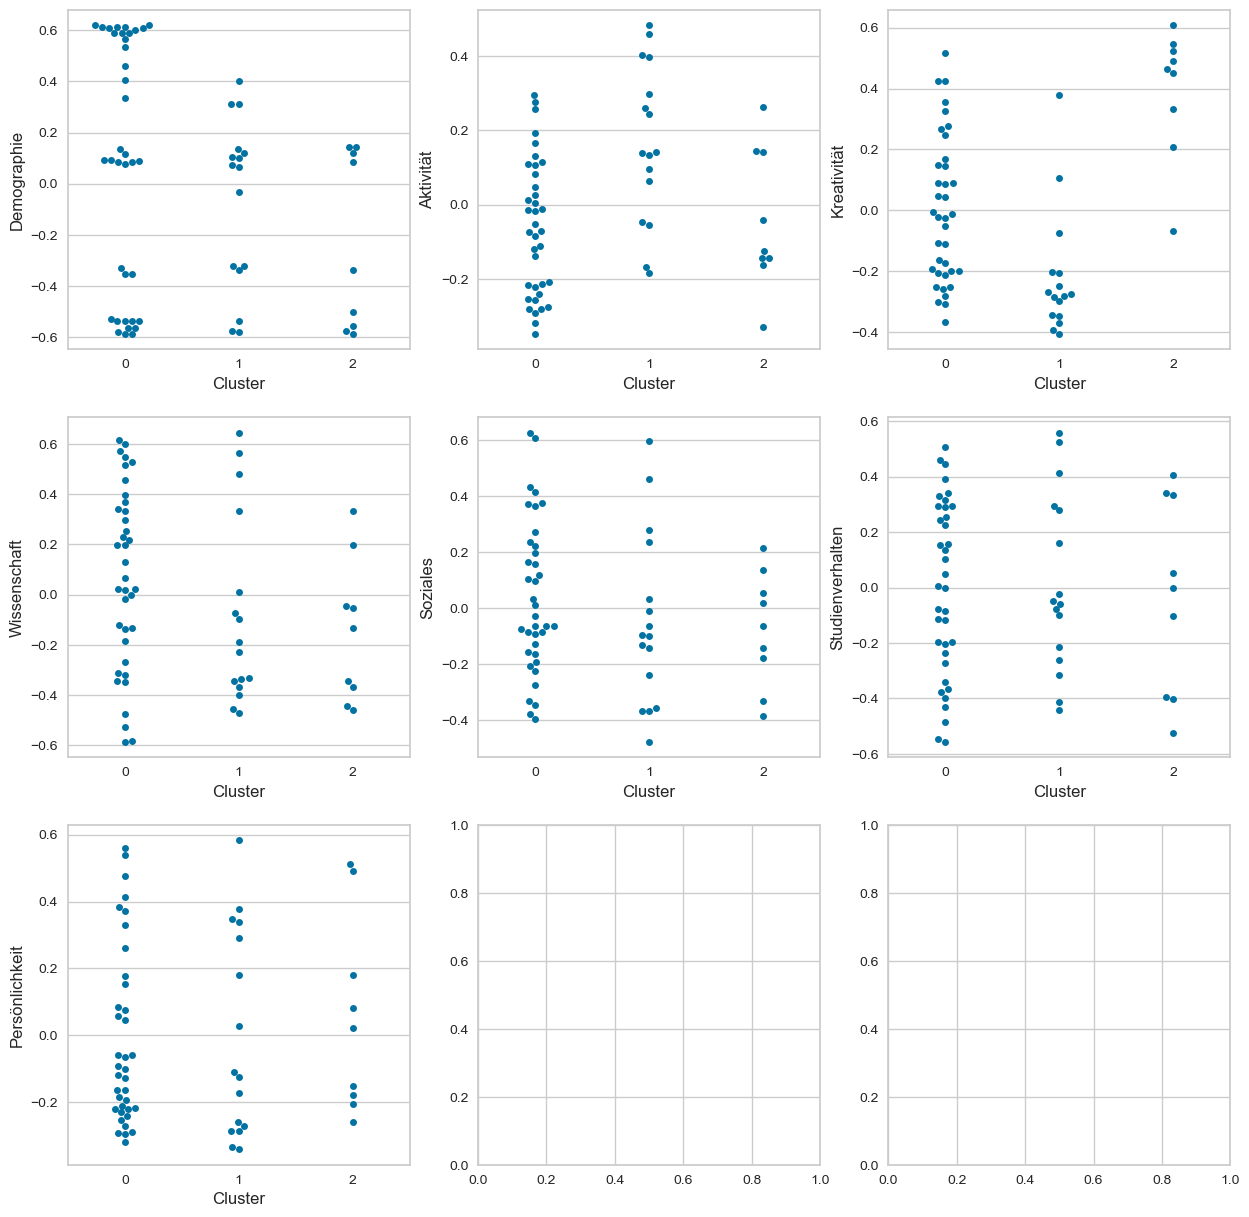

In [305]:
fig, ax = plt.subplots(3,3, figsize=(15, 15))

sb.swarmplot(x='Cluster', y="Demographie", data=data_topics, ax=ax[0, 0])
sb.swarmplot(x='Cluster', y="Aktivität", data=data_topics, ax=ax[0, 1])
sb.swarmplot(x='Cluster', y="Kreativität", data=data_topics, ax=ax[0, 2])
sb.swarmplot(x='Cluster', y="Wissenschaft", data=data_topics, ax=ax[1, 0])
sb.swarmplot(x='Cluster', y="Soziales", data=data_topics, ax=ax[1, 1])
sb.swarmplot(x='Cluster', y="Studienverhalten", data=data_topics, ax=ax[1, 2])
sb.swarmplot(x='Cluster', y="Persönlichkeit", data=data_topics, ax=ax[2, 0])

### 3.2.1 Untersuchung des Themenbereichs "Demographie"

<Axes: xlabel='Cluster', ylabel='Demographie'>

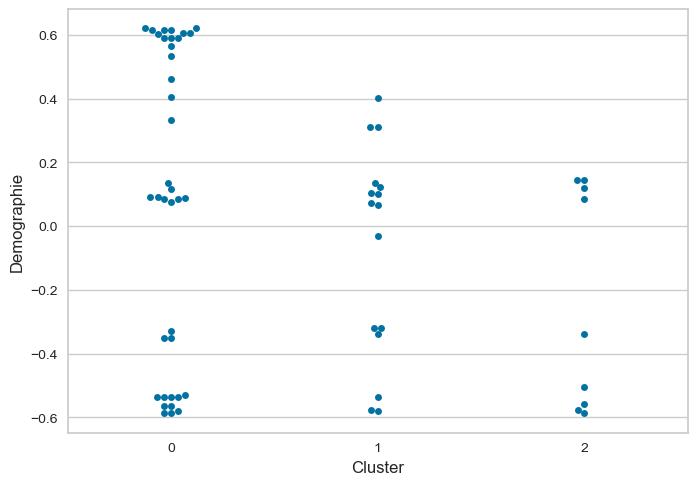

In [307]:
sb.swarmplot(x='Cluster',y="Demographie", data=data_topics)

Zunächst werden die bereits bei der Berechnung des Themenbereich erkannten, streifenartigen Strukturen untersucht. Hierzu wird der Themenbereich gegen einen beliebigen anderen aufgespannt, und die Datenpunkte gemäß ihrer Clusterzuordnung gefärbt. Für die y-Achse kann dabei ein beliebiger anderer Themenbereich gewählt werden, da dieser die Datenpunkte in der Darstellung nur auf der y-Achse verschieben kann.

<Axes: xlabel='Demographie', ylabel='Studienverhalten'>

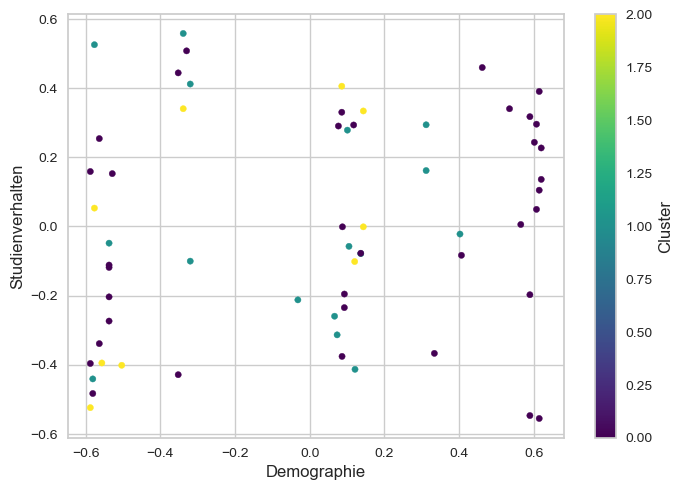

In [306]:
data_topics.plot(kind="scatter", x="Demographie", y="Studienverhalten", c="Cluster", cmap="viridis")

Es lässt sich feststellen, dass es keinen klaren Zusammenhang zwischen den berechneten Clustern und den intuitiv erkannbaren Strukturen der Berechnung der "Demographie"-Werte zu geben scheint. Bei der Zusammenfassung der Themenbereiche in Kapitel 2.4.2 der Dimensionsreduzierung wurde die räumliche Anordnung mit der Trennung nach Studiengängen begründet. Da diese Trennung bei den hierarchischen Clustering zumindest nicht nach demselben Schema erfolgte, wird zunächst die Alterverteilung der Datenpunkte als Ursache für die Zuordnung zu den Clustern untersucht.

In [308]:
df_cluster_ages = pd.DataFrame(columns=["Cluster", "Altersdurchschnitt", "1. STD Altersdurchschnitt"])

for cluster in data_encoded_clustered["Cluster"].unique():
    mask_cluster = data_encoded_clustered["Cluster"] == cluster
    ages = data_encoded_clustered[mask_cluster][columns_encoded.alter]
    df_cluster_ages.loc[len(df_cluster_ages)] = [cluster, ages.mean(), ages.std()]
    df_cluster_ages = df_cluster_ages.round(2)
    df_cluster_ages = df_cluster_ages.sort_values("Cluster")

df_cluster_ages

Cluster  Altersdurchschnitt  1. STD Altersdurchschnitt
0      0.0               25.00                       4.54
1      1.0               26.88                       4.98
2      2.0               25.33                       3.00

<Axes: xlabel='Cluster', ylabel='Alter'>

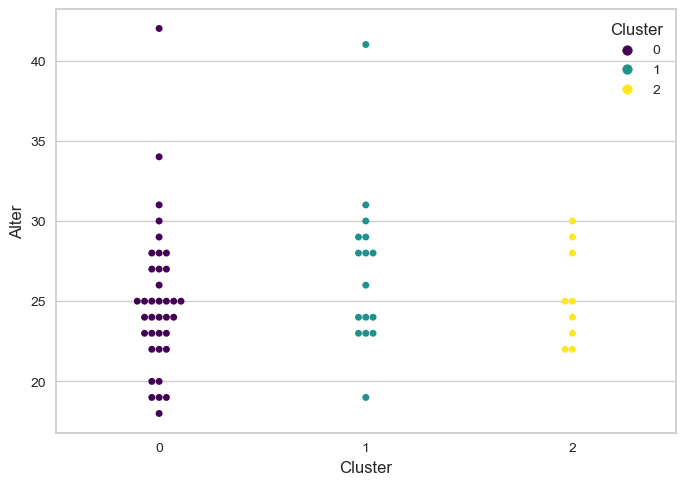

In [309]:
sb.swarmplot(data=data_encoded_clustered, x='Cluster', y=columns.alter, hue='Cluster', palette="viridis")

Anhand des Alterdurchschnitts, der Standardabweichung und der Grafik mit der Verteilung des Alters, dass das Clustering zumindest nicht ausschließlich auf dem Alter der enthaltenen Datenpunkte beruht. Alle Cluster weisen ein fast gleiches Durchschnittsalter auf, lediglich anhand der Standardabweichung und der graphischen Darstellung zeigt sich, dass das Cluster 0 viele jüngere Personen umfasst, was jedoch auch von der unterschiedlichen Anzahl der Datenpunkte in den Clustern beeinflusst sein kann.

Zum Vergleich der anderen im Themenfeld "Demographie" enthaltenen Features werden jeweils die Mittelwerte berechnet und graphisch dargestellt.

<Axes: >

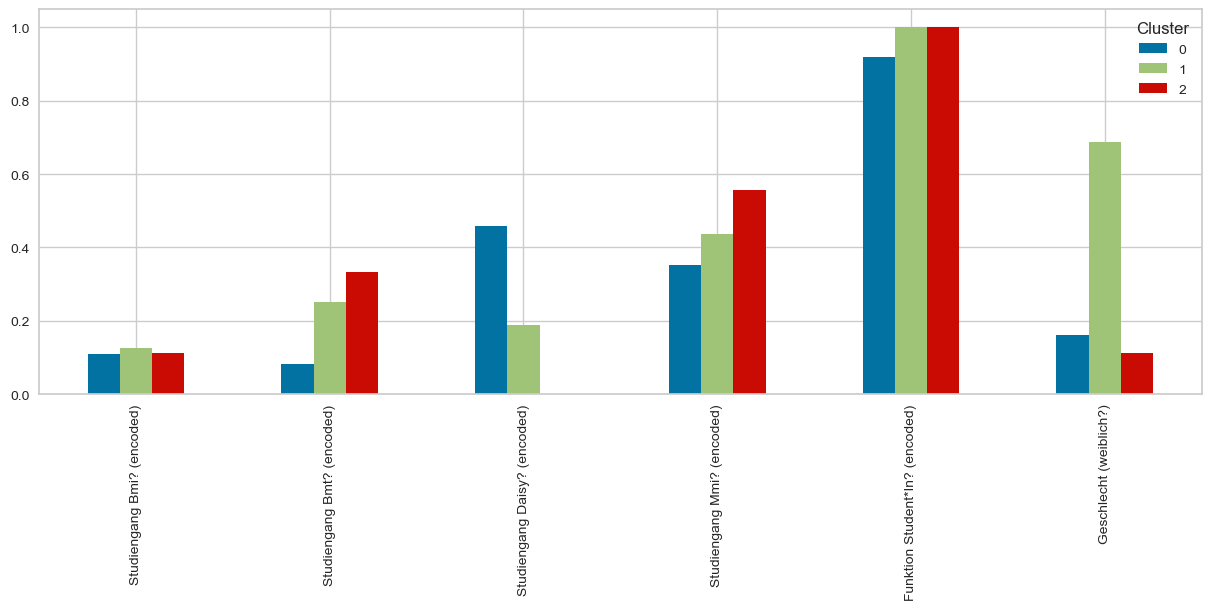

In [310]:
cat_demography = ("Demographie", ["alter", "studiengang_bmi", "studiengang_bmt", "studiengang_daisy",
              "studiengang_mmi", "funktion_student*in", "geschlecht_weiblich"])

data_topics_demo = data_encoded[[columns_encoded[cat] for cat in cat_demography[1]]].copy()
data_topics_demo["Cluster"] = cluster_labels
data_topics_demo = data_topics_demo.groupby("Cluster").mean()

data_topics_demo = data_topics_demo.drop("Alter", axis=1)
data_topics_demo.T.plot(kind="bar", figsize=(15,5))

Im Vergleich zum Alter lassen sich aus den anderen Features schon eher Aussagen über die Cluster treffen. Da alle Features nur Werte von 0 oder 1 annehmen können, ist der Mittelwert zum zusammenfassen der Daten geeignet, da es keine Ausreißer geben kann, die die Verteilung der Daten beeinflussen könnten.

So scheint Cluster 0 einen Großteil der DAISY-Studierenden zu umfassen, und dafür vergleichsweise wenig Studierende der anderen Bachelor-Studiengänge. Dazu sind die drei nicht-Studierenden in Cluster 0 enthalten. Im Gegensatz dazu besitzt Cluster 2 keine\*n einzige*\n DAISY-Studierende\*n, sondern vor allem BMT- sowie MMI-Studierende. Weiterhin fällt auf, dass Cluster 1 einen Großteil der weiblichen Studierenden umfasst.

### 3.2.2 Untersuchung des Themenbereichs "Kreativität"

Wie im Swarmplot zu sehen ist, scheinen insbesondere die Cluster 1 und 2 auffällige Muster zu zeigen: Währende den Personen in Cluster 1 eher niedrigere Werte zugeordnet werden, sind diese im Cluster 2 auffällig hoch.

<Axes: xlabel='Cluster', ylabel='Kreativität'>

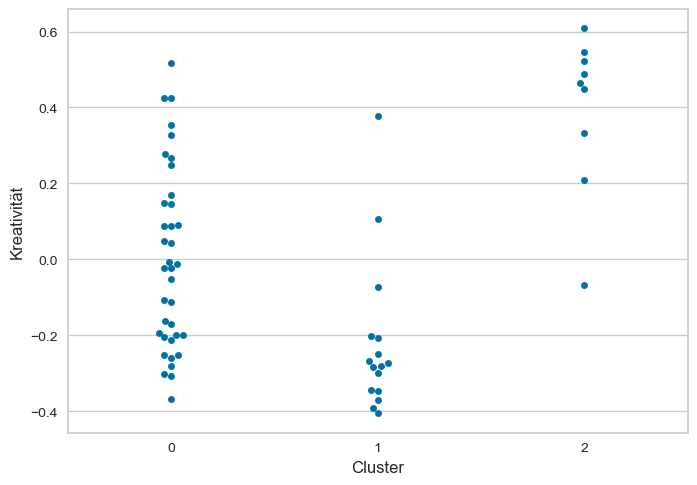

In [311]:
sb.swarmplot(x='Cluster',y="Kreativität", data=data_topics)

Ähnlich zum Vorgehen im letzten Kapitel werden die durchschnittlichen Werte der einzelnen Feature mit der Zuordnung zu den Clustern dargestellt.

<Axes: >

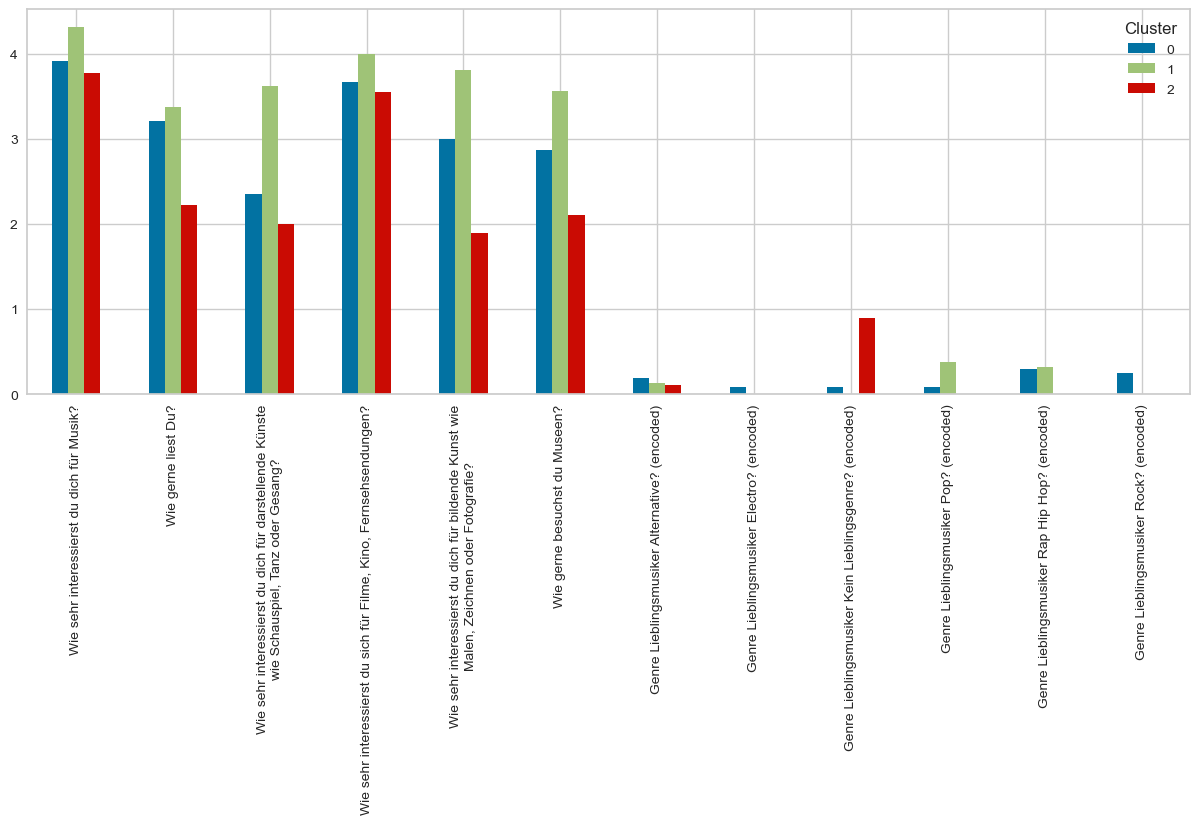

In [312]:
cat_creativity = ("Kreativität", ["musik", "lesen", "schauspiel", "filme", "malen", "museumsbesuche",
              "genre_lieblingsmusiker_alternative",
              "genre_lieblingsmusiker_electro",
              "genre_lieblingsmusiker_kein_lieblingsgenre",
              "genre_lieblingsmusiker_pop",
              "genre_lieblingsmusiker_rap_hip_hop",
              "genre_lieblingsmusiker_rock"])

data_topics_creativity = data_encoded[[columns_encoded[cat] for cat in cat_creativity[1]]].copy()
data_topics_creativity["Cluster"] = cluster_labels
data_topics_creativity = data_topics_creativity.groupby("Cluster").mean()

data_topics_creativity.T.plot(kind="bar", figsize=(15,5))

#### Ergebnisse / Beobachtungen

In der Darstellung fallen einige Eigenschaften der Cluster auf:

__Cluster 0__

Dieses Cluster scheint alle Personen zu vereinen, deren Lieblingsmusiker*in dem Genre Rock (oder Electro) zuzuordnen sind. Ansonsten scheint das Interesse an den Themen Kunst, Kultur und Musik im Vergleich zu den anderen Clustern recht durchschnittlich zu sein.

__Cluster 1__

Die Personen im Cluster 1 scheinen im Vergleich mit den anderen Clustern das höchste Interesse an Kunst und Kultur zu haben, was an den stets höchsten Durchschnittswerten in den Antworten auf die Fragen abzulesen ist. Weiterhin scheinen die meisten Personen Pop oder Hip Hop zu hören.

__Cluster 2__

Dieses Cluster scheint alle Personen ohne Lieblingsgenre/-Musiker zu enthalten, gleichzeitig sind die Durschnittswerte für die Fragen nach Interessen im künstlerischen und kulturellen Bereich vergleichsweise niedrig. Diese Beobachtungen lassen sich derart interpretieren, dass sich die in Cluster 2 enthaltenen Personen tendenziell weniger für Kunst, Kultur und Musik zu interssieren scheinen.

Die Ergebnisse sind vor allem dahingehend interessant, als dass die hohen Werte von Cluster 2 für den Themenbereich im Swarmplot vermuten lassen könnten, dass sich die Personen dieses Clusters besonders für das Thema interessieren. Gleichzeitig waren die Werte im Cluster 1 eher niedrig; In der näheren Auswertung zeigt sich jedoch, dass gerade diese Personen sich besonders für Kunst und Kultur zu interessieren scheinen. Daher lässt sich eher vermuten, dass die hohen Werte für Cluster 2 darauf beruhen, dass die "positive" Angabe des Features "Kein Lieblingsmusikers" eine größere Gewichtung dieses Features bei der Dimensionreduzierung zur Folge hatte. Da für die Berechnung der Werte Kernel PCA genutzt wurde, wurde hier eventuell eine Struktur erkannt, die bei der Reduzierung beibehalten wurde.

# 4. Fazit

Da sowohl die Dimensionsreduzierung als auch das Clustering "ill-defined-problems" darstellen, ist eine erschöpfende Untersuchung aller Möglichkeiten und Kombination von Ergebnisse so gut wie unmöglich. Dennoch konnten einige Verfahren und Kombinationen von reduzierten Daten und Clustering-Algorithmen als besser oder schlechter herausgestellt werden. Dabei wurde deutlich, dass in den meisten Fällen das Clusteringverfahren an sich über die Erkennbarkeit von Clustern in den reduzierten Daten entschieden hat. Wenn Strukturen und Muster erkennbar waren, dann fast immer für Ergebnisse aller berechneten Dimensionsreduzierungen. Am Ende haben sich vor allem die Clustering-Algorithmen k-Means und das hierarchische Clustering als zielführend herausgestellt, die auf allen Reduktions-Verfahren erkennbare Cluster bildeten.

Das Clustering kann abgesehen von der visuellen Erkennbarkeit in den Graphen auch im Hinblick auf die Aussagekraft über die Daten als erkenntnisbringend bewertet werden. So können die drei berechneten Cluster wie folgt zusammengefasst werden: Cluster 2 enthält größtenteils männliche Personen aus den Studienfächern MMI und BMT, die eher desinteressiert an Kunst und kulturellen Unternehmungen sind. In Cluster 1 sind hingegen viele weibliche Studierende zu finden, die besonders stark an Kunst, Kultur und Musik interessiert sind. Im größten Cluster 0 befinden sich vor allem DAISY-Studierende, die ein gemischtes Interesse an kulturellen Unternehmungen haben. Cluster 0 umfasst dabei auch viele der jüngeren Studierenden. Dieses Cluster bildet somit gedanklich die "breite Masse" ab. Im zugehörigen Dendogramm zeigt sich, dass dieses Cluster bei einer weiteren Unterteilung in kleinere Cluster aufgeteilt werden würde, die eventuell weitere, spezifischere Personengruppen hervorbringen. Aufgrund des Umfangs der Untersuchung wurden hier aber vorerst keine weiteren Nachforschungen angestellt.